In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

from confusion_matrix import plot_confusion_matrix

In [3]:
# Plots stuff
from pylab import rcParams

rcParams['figure.figsize'] = 16, 16
%matplotlib inline

sns.set()

plt.rcParams['figure.dpi'] = 100

In [4]:
random_seed = 2512
random_state = np.random.RandomState(random_seed)

# Loading and preparing data

In [5]:
OUTCOMES = ['Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp',]
AMBIGUOUS_COLUMNS = ['PRU_more208', 'PRU_less95', 'C_rivar_137', ]
STRING_COLUMNS = ['AF_type', 'Stent_type', 'CYP4F2', 'P2Y12'] # These columns should be encoded with LabelEncoder
MAX_PRU = 208 # Maximum and minimum PRU borders, lower and higher is an unsafe zone
MIN_PRU = 95
UNNEEDED_COLUMNS = [
    'Agr_Platelets_Cat',
    'Residual_more230',
    'Residual_reactivity_less85',
    'CrusadeScore_bleeding',
    'Acatalepsia',
    'Gastric',
]
NUMERIC_COLUMNS = [
    'Age',
    'GFR',
    'PRU',
    'Rivaroxaban_C_blood',
    'inhibition',
    'CRUSADE',
    'SYNTAX_score',
    'Hb',
    'CHA2DS2VASC',
    'Hasbled',
    'Agr_Platelets_base',
    'Rivaroxaban_dose',
]

In [6]:
df = pd.read_csv('Rivaroxaban_fg.csv', header=0, index_col=0)[:103]

SINGLE_VALUE_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 1]
SUSPICIOUS_MISSING_VALUES_COLUMNS = [col for col in df.columns if '-999' in df[col].unique()]
BINARY_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 2]

df = df.drop([*UNNEEDED_COLUMNS, *SINGLE_VALUE_COLUMNS], axis=1)

for outcome in OUTCOMES:
    df[outcome] = df[outcome].replace(' ', 0).astype(float)

for numeric_col in NUMERIC_COLUMNS:
    df[numeric_col] = df[numeric_col].astype(float)

for category_col in STRING_COLUMNS:
    encoder = LabelEncoder()
    df[category_col + '_encoded'] = encoder.fit_transform(df[category_col])
    

In [7]:
BINARY_VALUES_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 2]
BINARY_VALUES_COLUMNS

['Sex',
 'PRU_more208',
 'PRU_less95',
 'C_rivar_137',
 'STEMI',
 'NSTEMI',
 'Unstableangina',
 'PCI',
 'Death_inhosp',
 'Obesity',
 'Alcohol',
 'Smoking',
 'Cardiosclerosis',
 'Previous_PCI',
 'PreviousCABG',
 'HighriskSYNTAX',
 'Grace_score_risk',
 'Heart_Stop',
 'Hypertension',
 'HeartFailure_before',
 'Stroke',
 'Previous_thromboses',
 'Diabetes',
 'PAD',
 'COPD',
 'Onco',
 'Previous_bleeding',
 'Anaemialessthan100',
 'Plateletslessthan100',
 'Highplateletsondischarge',
 'Death_and_renal_failure',
 'RenalFailure',
 'HeartFailure',
 'HasBLED39',
 'DAPT_TAPT',
 'Significant_bleeding_outcome',
 'Stroke_outcome',
 'CYP3A4_22',
 'CYP3A5_3_A6986G',
 'ABCB1_3435_Short',
 'ABCB1_rs4148738_Short',
 'CYP2C19_2_Short',
 'CYP2C19_17_Short',
 'CES1',
 'CYP3A4_2242480',
 'PON1',
 'IGTB3',
 'PEAR1_rs41273215']

In [8]:
SUSPICIOUS_MISSING_VALUES_COLUMNS

['Access', 'Stent_quant', 'SYNTAX_score']

# Initial analysis

In [9]:
SINGLE_VALUE_COLUMNS

['Thrombosysis', 'CYP2C19_3_G636A']

In [10]:
df.head()

Sex   Age  Rivaroxaban_C_blood  Agr_Platelets_base  inhibition    PRU  \
Number                                                                         
1        1  81.0                204.0               195.0        48.0  102.0   
2        1  88.0                134.0               196.0        28.0  141.0   
3        1  81.0                242.0               211.0        13.0  183.0   
4        0  73.0                 57.0               163.0        12.0  144.0   
5        0  61.0                 37.0               182.0        11.0  162.0   

       PRU_more208 PRU_less95 C_rivar_137 STEMI  ... CES1 CYP3A4_2242480 PON1  \
Number                                           ...                            
1                2          2           1     0  ...    1              1    2   
2                2          2           0     0  ...    1              1    2   
3                2          2           1     0  ...    2              1    2   
4                2          2           0     0  ...    2              1    2   
5                2          2           0     0  ...    1              1    2   

       IGTB3  P2Y12 PEAR1_rs41273215 AF_type_encoded Stent_type_encoded  \
Number                                                                    
1          1      1                1               2                  2   
2          2      1                1               2                  0   
3          1      2                2               2                  3   
4          2      2                2               1                  3   
5          1      2                1               1                  3   

       CYP4F2_encoded P2Y12_encoded  
Number                               
1                   2             1  
2                   1             1  
3                   2             2  
4                   2             2  
5                   2             2  

[5 rows x 76 columns]

In [11]:
df.columns

Index(['Sex', 'Age', 'Rivaroxaban_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'PRU_more208', 'PRU_less95', 'C_rivar_137', 'STEMI', 'NSTEMI',
       'Unstableangina', 'PCI', 'AF_type', 'Death_inhosp', 'Obesity',
       'Alcohol', 'Smoking', 'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG',
       'Access', 'Stent_type', 'Stent_quant', 'HighriskSYNTAX',
       'Grace_score_risk', 'SYNTAX_score', 'CRUSADE', 'Killip', 'Heart_Stop',
       'Hypertension', 'HeartFailure_before', 'Stroke', 'Previous_thromboses',
       'Diabetes', 'PAD', 'COPD', 'Onco', 'Previous_bleeding',
       'Anaemialessthan100', 'Plateletslessthan100',
       'Highplateletsondischarge', 'Death_and_renal_failure', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose',
       'Significant_bleeding_outcome', 'Stroke_outcome', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP

Text(0.5, 1.0, 'Data points distribution by Sex')

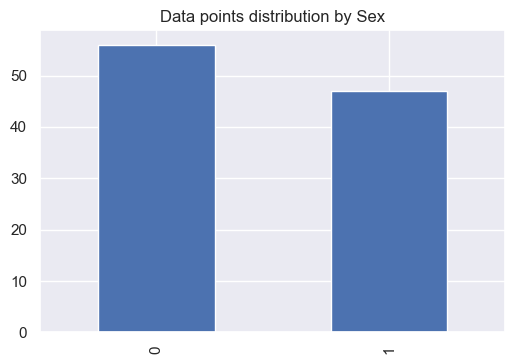

In [12]:
ax = df.Sex.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Sex')

Text(0.5, 1.0, 'Age distribution')

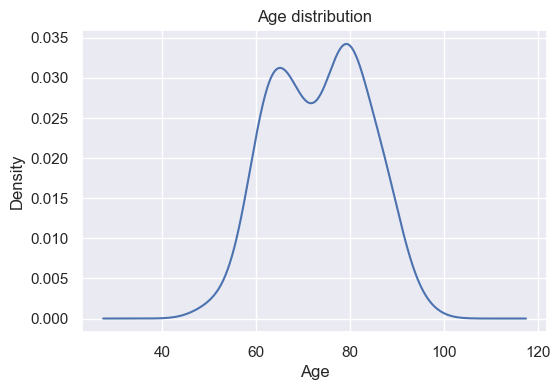

In [13]:
fig, ax = plt.subplots()
df.Age.plot(kind='kde')
ax.set_xlabel('Age')
ax.set_title('Age distribution')

Text(0.5, 1.0, 'Rivaroxaban_C_blood distribution')

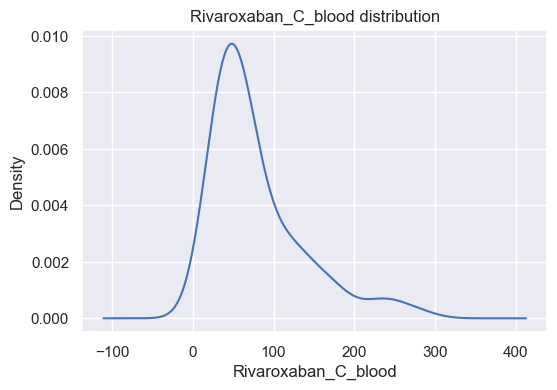

In [14]:
fig, ax = plt.subplots()
df.Rivaroxaban_C_blood.plot(kind='kde')
ax.set_xlabel('Rivaroxaban_C_blood')
ax.set_title('Rivaroxaban_C_blood distribution')

Text(0.5, 1.0, 'Agr_Platelets_base distribution')

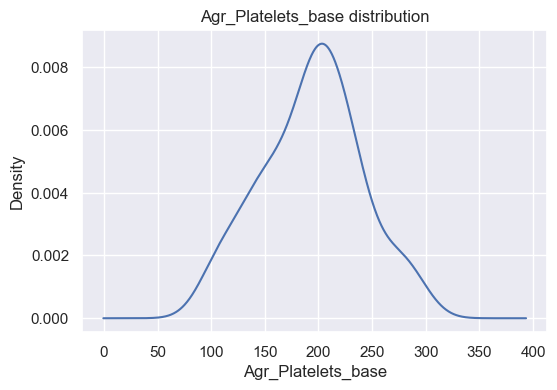

In [15]:
fig, ax = plt.subplots()
df.Agr_Platelets_base.plot(kind='kde')
ax.set_xlabel('Agr_Platelets_base')
ax.set_title('Agr_Platelets_base distribution')

Text(0.5, 1.0, 'GFR distribution')

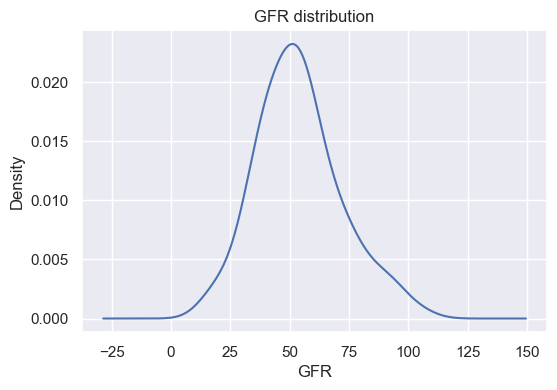

In [16]:
fig, ax = plt.subplots()
df.GFR.plot(kind='kde')
ax.set_xlabel('GFR')
ax.set_title('GFR distribution')

Text(0.5, 1.0, 'PRU distribution')

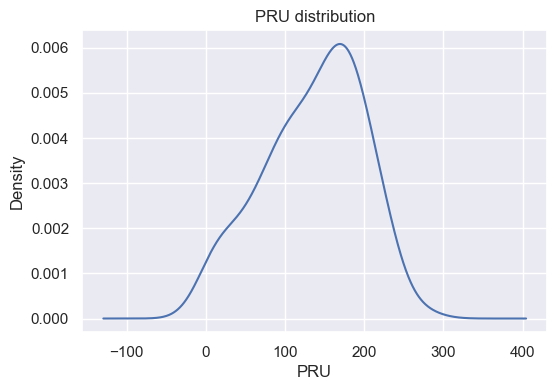

In [17]:
fig, ax = plt.subplots()
df.PRU.plot(kind='kde')
ax.set_xlabel('PRU')
ax.set_title('PRU distribution')

## Outcomes barplots

In [18]:
df_outcomes = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *AMBIGUOUS_COLUMNS,
        ]
    ]
]
df_outcomes = df_outcomes.replace(' ', 0)

def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0].replace('_', ' ')
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death renal failure bleeding' # Maybe later we'll have enough data points to consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death in hospital bleeding' # Maybe later we'll have enough data points to consider this outcome
    else:
        return 'Death and renal failure'

df_outcomes['Outcome'] = df.apply(
    _process_row_outcomes,
    axis = 1
)


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

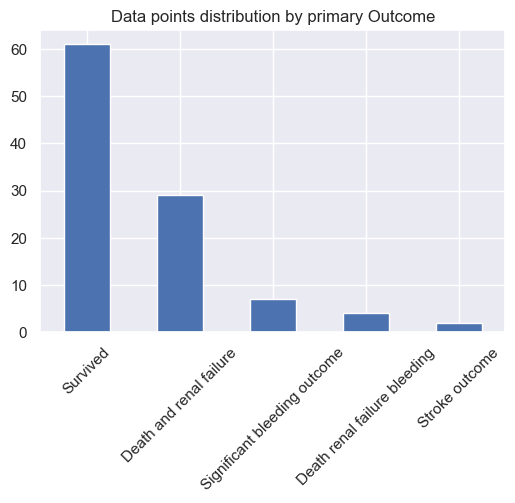

In [37]:
ax = df_outcomes.Outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by primary Outcome')
plt.xticks(rotation=45)

# Task number 1

Concentration prediction

Target columns -> `'Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp'`


## [Survived/Died] classification - using LOOCV

### Data preparation

In [38]:
preprocessed_classification_df = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *AMBIGUOUS_COLUMNS,
        ]
    ]
]
preprocessed_classification_df = preprocessed_classification_df.replace(' ', 0)

In [39]:
df2=preprocessed_classification_df.copy(deep=True)

### Outcome column generation

In [40]:
def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0]
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death_renal_failure_bleeding' # Maybe later we'll have enough data points to consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death_in_hospital_bleeding' # Maybe later we'll have enough data points to consider this outcome
    else:
        return 'Death_renal_failure_inhosp'


def process_row_outcomes_survived(row):
    outcome = _process_row_outcomes(row)
    if 'Death' in outcome: # TODO Discuss
        return 'Death'
    elif (
        outcome == 'Significant_bleeding_outcome' or 
        outcome == 'Stroke_outcome'
    ):
#         return 'Bleeding_or_stroke'
        return 'Survived'
    return outcome




df2['Outcome'] = df.apply(
    process_row_outcomes_survived,
    axis = 1
)

encoder = LabelEncoder()
df2['Outcome_encoded'] = encoder.fit_transform(df2.Outcome)
X = df2[[col for col in df2.columns if not col.startswith('Outcome')]]
Y = df2['Outcome_encoded']
CLASS_NAMES = encoder.classes_


### Testing models using all features

In [41]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression

def evaluate_with_conf_matrix_loocv(model, X, Y, model_name, class_names):
    ##### LOOCV MODEL EVALUATION AND CONFUSION MATRIX PLOT
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    predictions = []
    coefficients = []


    for train, test in loo.split(X):
        predictions.append(model.fit(X.iloc[train], Y.iloc[train]).predict(X.iloc[test])[0])
        coefficients.append(
            model.coef_[0] if name != 'Random Forest' else model.feature_importances_,
        )

    predictions = pd.Series(predictions)

    with sns.axes_style("darkgrid", {"axes.grid": False}):
        plot_confusion_matrix(
            Y,
            predictions,
            classes=class_names,
            normalize=False,
            title=f'Confusion matrix for {model_name}'
        )
    return np.array(coefficients).mean(axis=0)

        
def plot_important_features(X, coefficients, name, normalize=True):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = min(20, X.shape[1]) # Plot up to 20 most important features
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(
        map(
            lambda pair: pair[1] != abs(pair[1]) and ('[negative]' + pair[0], abs(pair[1])) or (pair[0], pair[1]),
            feature_importance
        ),
        key=lambda x:x[1], reverse=True))
    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel(f'Importance/coefficients for {name}')

    plt.show()

################################### SVC ###################################
Confusion matrix, without normalization
[[31  2]
 [ 0 70]]


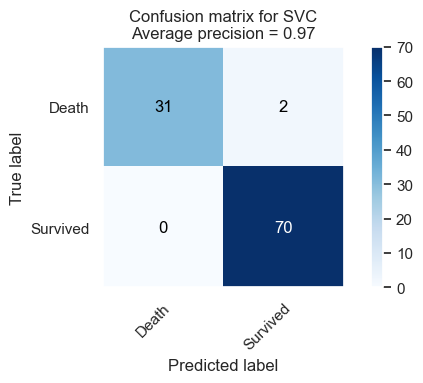

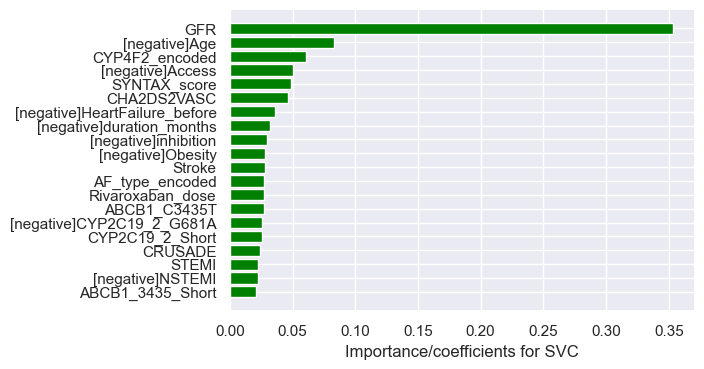

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


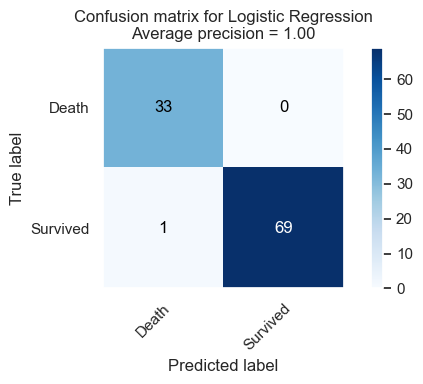

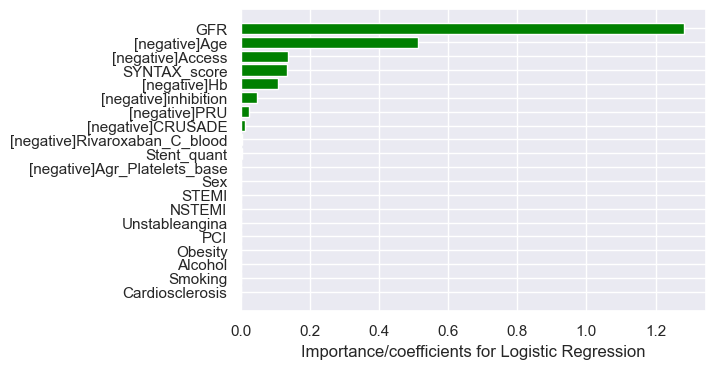

<Figure size 1000x700 with 0 Axes>

In [23]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
#     ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )




### Removing insignificant variables

In [24]:
transforming_model = SelectFromModel(log_reg, prefit=True)
X_transformed = transforming_model.transform(X)
feature_idx = transforming_model.get_support()
feature_names = X.columns[feature_idx]
X_transformed = pd.DataFrame(X_transformed, columns=X.columns[feature_idx])


In [25]:
feature_names

Index(['Age', 'Rivaroxaban_C_blood', 'inhibition', 'PRU', 'Access',
       'Stent_quant', 'SYNTAX_score', 'CRUSADE', 'Hb', 'GFR'],
      dtype='object')

### Testing models using only significant columns

################################### Random Forest ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


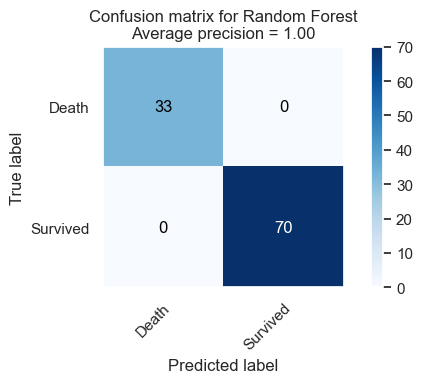

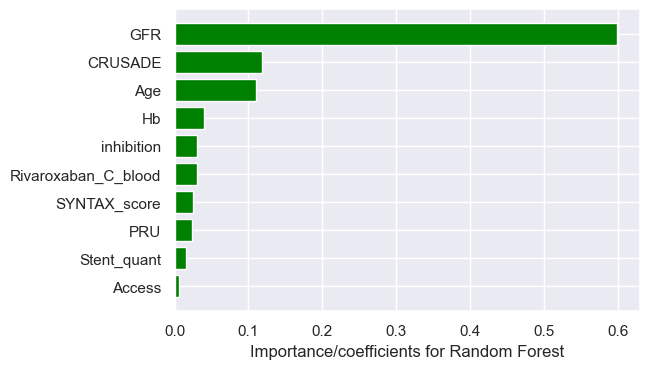

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


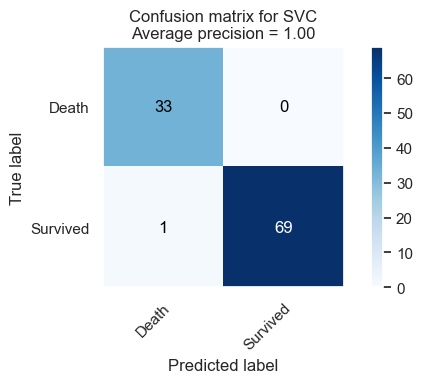

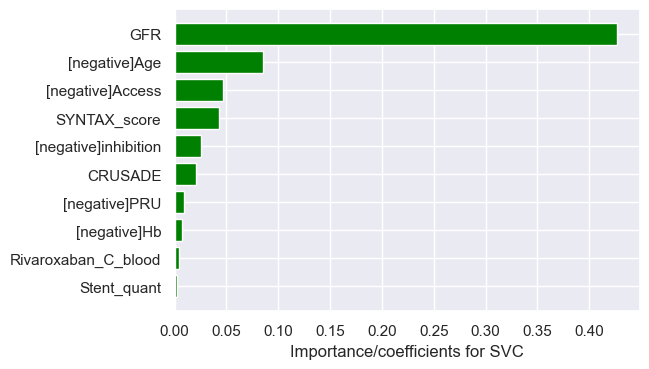

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexa

Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


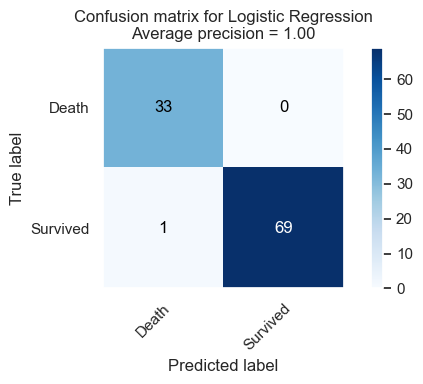

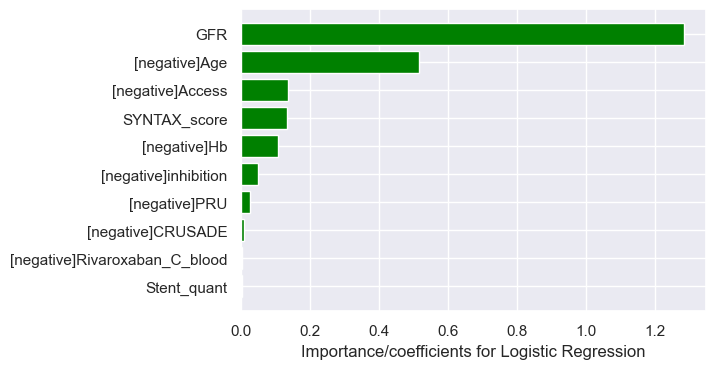

<Figure size 1000x700 with 0 Axes>

In [26]:
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X_transformed, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_transformed,
        coefs,
        name,
    )



### Running models without GFR variable

################################### Random Forest ###################################
Confusion matrix, without normalization
[[18 15]
 [ 8 62]]


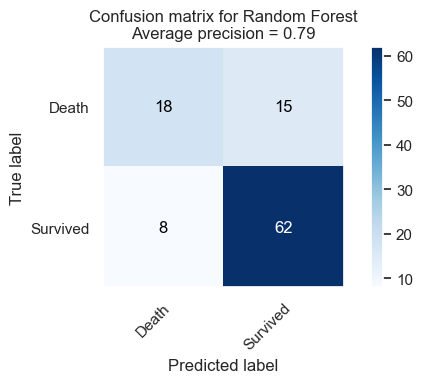

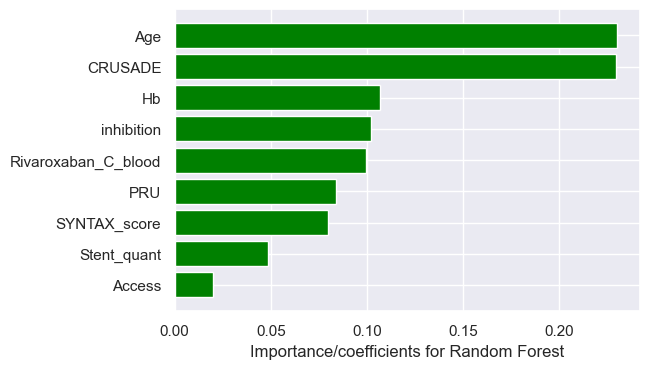

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[22 11]
 [12 58]]


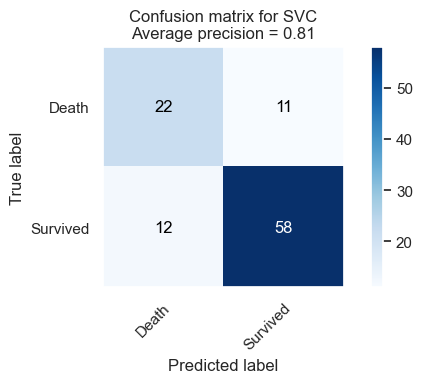

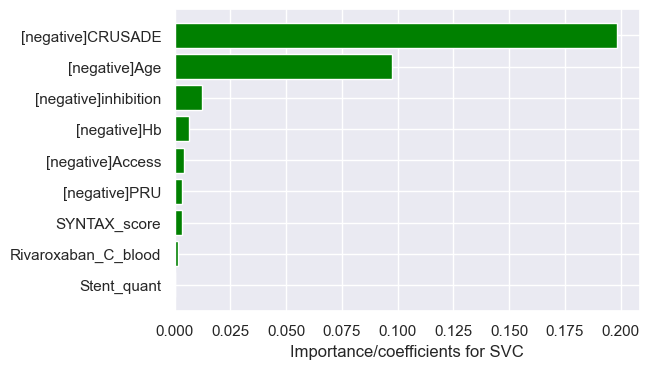

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[18 15]
 [13 57]]


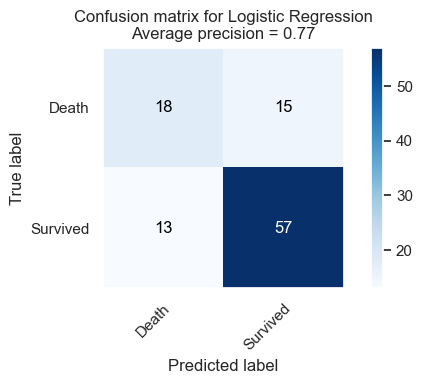

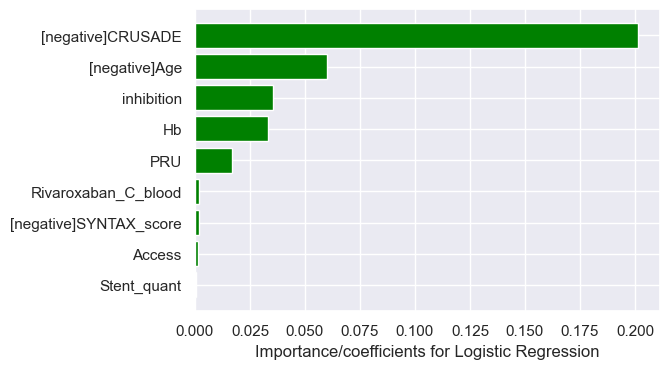

<Figure size 1000x700 with 0 Axes>

In [27]:
X_no_gfr = X_transformed.drop('GFR', axis=1)

for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X_no_gfr, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_no_gfr,
        coefs,
        name,
    )



### Running models with only GFR and Age variables

################################### Random Forest ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


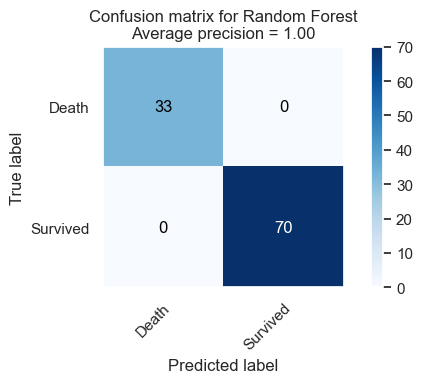

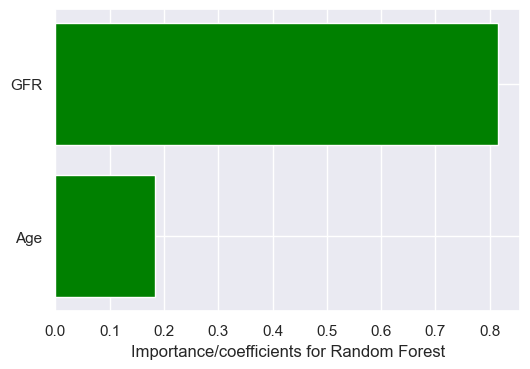

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


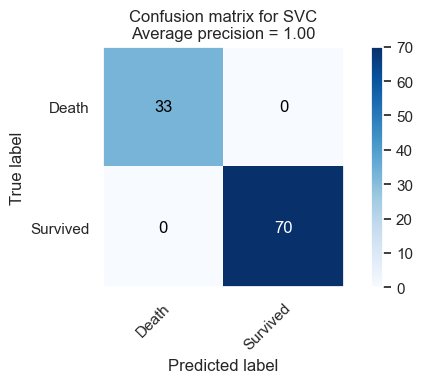

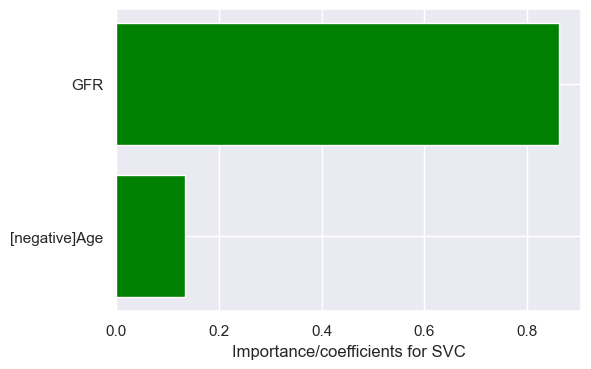

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexa

Confusion matrix, without normalization
[[32  1]
 [ 1 69]]


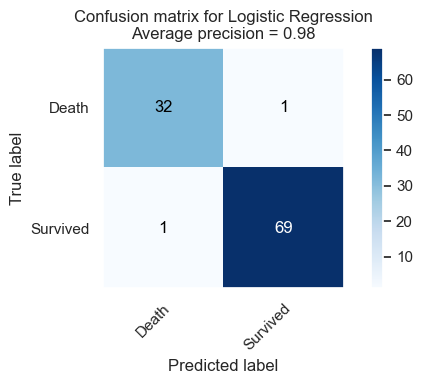

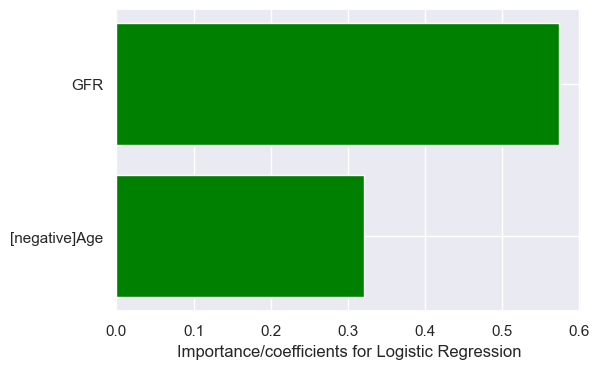

<Figure size 1000x700 with 0 Axes>

In [28]:
X_age_gfr = X_transformed[['GFR', 'Age']]

for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X_age_gfr, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_age_gfr,
        coefs,
        name,
    )



## [Bleeding/No bleeding] classification - using LOOCV

### Outcome column generation

In [29]:
df5 = preprocessed_classification_df.copy(deep=True)

df5['Outcome'] = df.Significant_bleeding_outcome.astype(int)


X = df5.drop('Outcome', axis=1)
Y = df5['Outcome']
CLASS_NAMES = np.array(['No bleeding', 'Bleeding'])

In [30]:
Y.unique(), CLASS_NAMES

(array([0, 1]), array(['No bleeding', 'Bleeding'], dtype='<U11'))

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

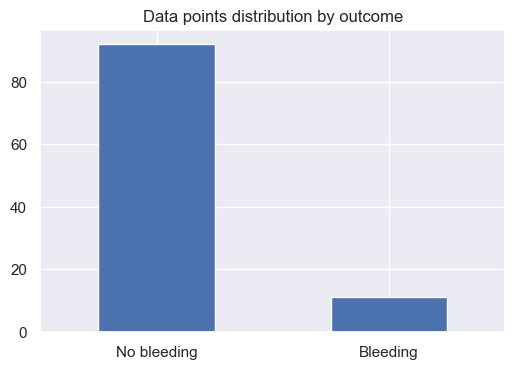

In [31]:
ax = df5.Outcome.value_counts().plot(kind='bar')
ax.set_xticklabels(CLASS_NAMES)
ax.set_title('Data points distribution by outcome')
plt.xticks(rotation=0)

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[92  0]
 [11  0]]


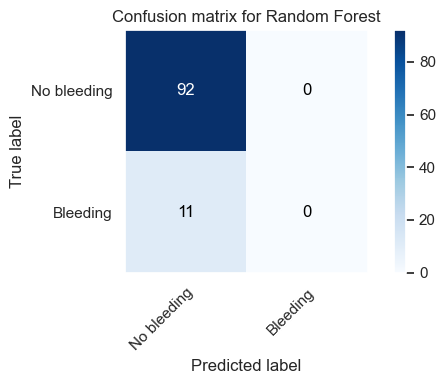

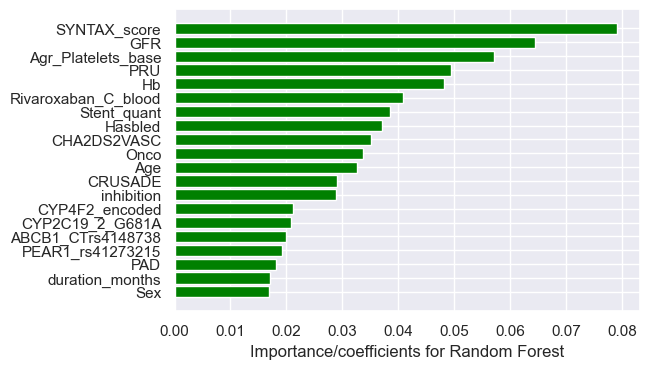

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[81 11]
 [ 9  2]]


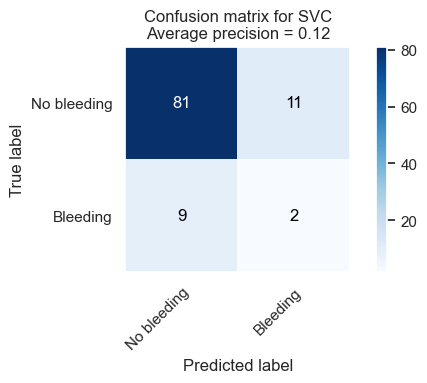

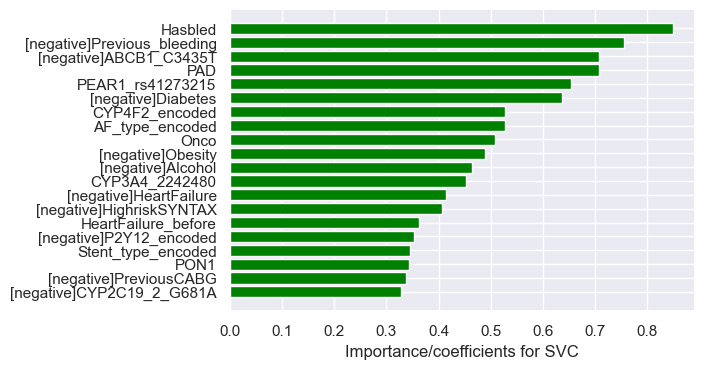

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[84  8]
 [10  1]]


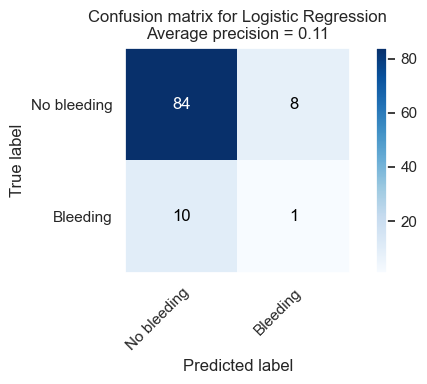

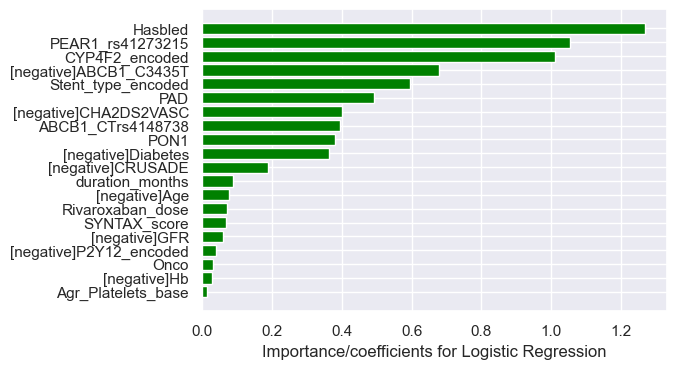

<Figure size 1000x700 with 0 Axes>

In [32]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## [PRU normal/higher than 208/less than 95] classification - using LOOCV

### Outcome column generation


In [33]:
df3 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes_PRU(row):
    if row.PRU < MIN_PRU :
        outcome = '<95'
    elif row.PRU > MAX_PRU:
        outcome = '>208'
    else:
        outcome = 'Normal'
    return outcome


df3['PRU_outcome'] = df.apply(
    process_row_outcomes_PRU,
    axis = 1
)
encoder = LabelEncoder()
df3['PRU_outcome_encoded'] = encoder.fit_transform(df3.PRU_outcome)

df3 = df3.drop([col for col in df3.columns if col.startswith('Outcome')] + ['PRU'], axis=1)

X = df3[[col for col in df3.columns if not col.startswith('PRU')]]
Y = df3['PRU_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

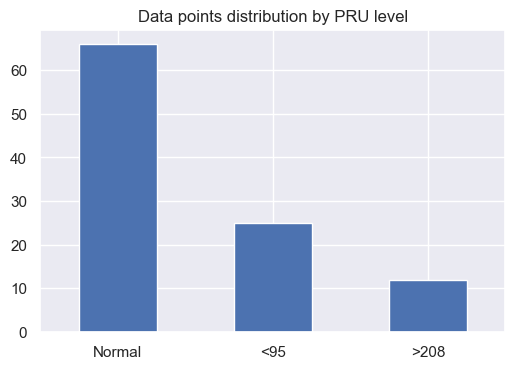

In [34]:
ax = df3.PRU_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by PRU level')
plt.xticks(rotation=0)

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[ 7  1 17]
 [ 0  3  9]
 [ 4  1 61]]


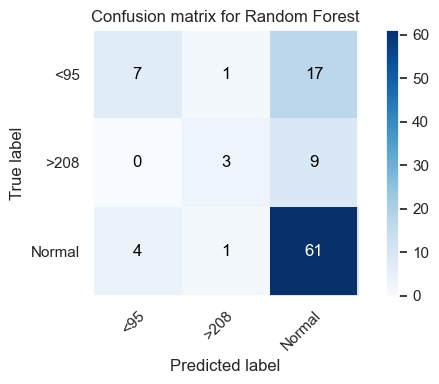

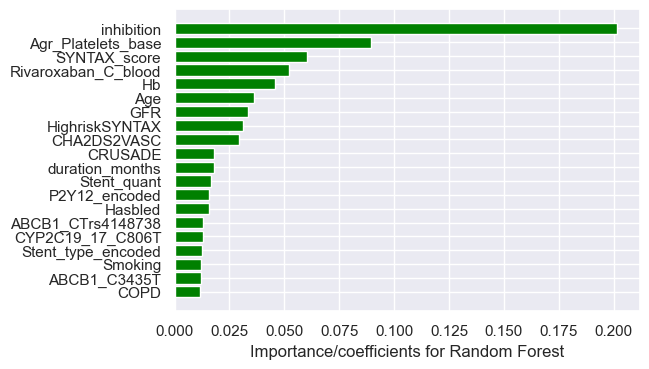

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[21  0  4]
 [ 0  7  5]
 [ 4  3 59]]


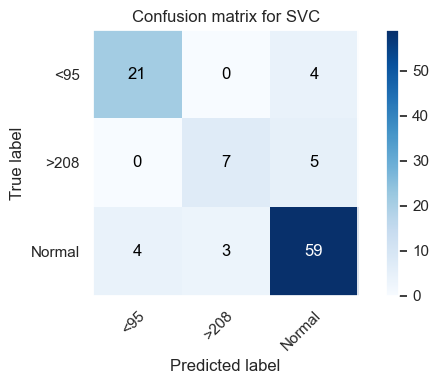

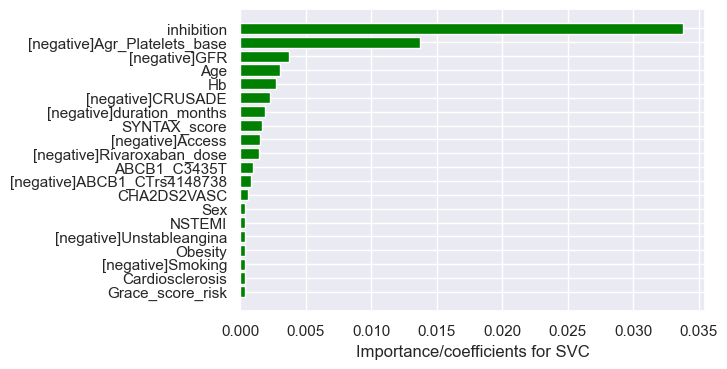

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexa

Confusion matrix, without normalization
[[21  0  4]
 [ 0  6  6]
 [ 3  1 62]]


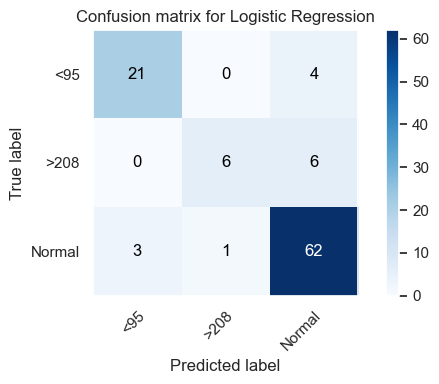

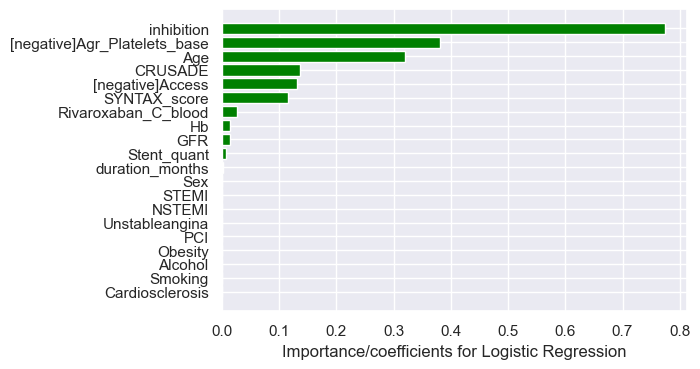

<Figure size 1000x700 with 0 Axes>

In [35]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## [Concentration higher/lower than 137] classification - using LOOCV

### Outcome column generation


In [36]:
df4 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes_c(row):
    if row.Rivaroxaban_C_blood <= 137 :
        outcome = '<=137'
    else:
        outcome = '>137'
    return outcome


df4['C_rivar_137_outcome'] = df.apply(
    process_row_outcomes_c,
    axis = 1
)
encoder = LabelEncoder()
df4['C_rivar_137_outcome_encoded'] = encoder.fit_transform(df4.C_rivar_137_outcome)

df4 = df4.drop([col for col in df4.columns if col.startswith('Outcome')] + ['Rivaroxaban_C_blood'], axis=1)

X = df4[[col for col in df4.columns if not col.startswith('C_rivar')]]
Y = df4['C_rivar_137_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

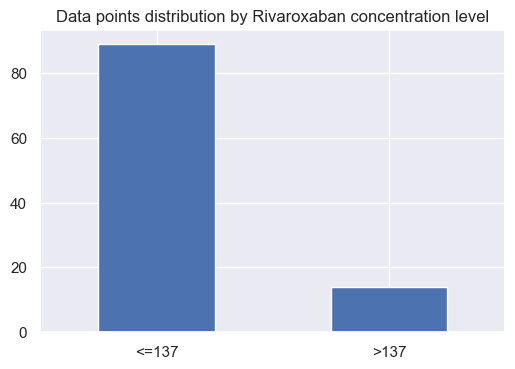

In [37]:
ax = df4.C_rivar_137_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Rivaroxaban concentration level')
plt.xticks(rotation=0)

In [38]:
df4.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score',
       'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB1_3435_Short',
       'ABCB1_rs4148738_Short', 'CYP2C19_2_Short', 'CYP2C19_17_Short', 'CES1',
       'CYP3A4_2242480', 'PON1', 'IGTB3', 'PEAR1_rs41273215',
       'AF

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[89  0]
 [14  0]]


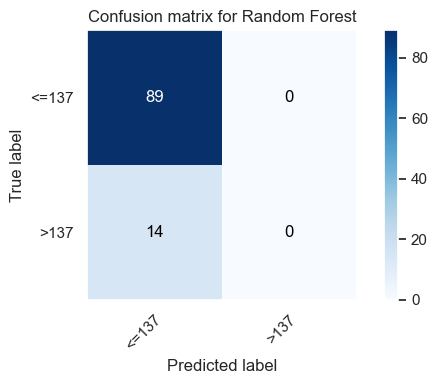

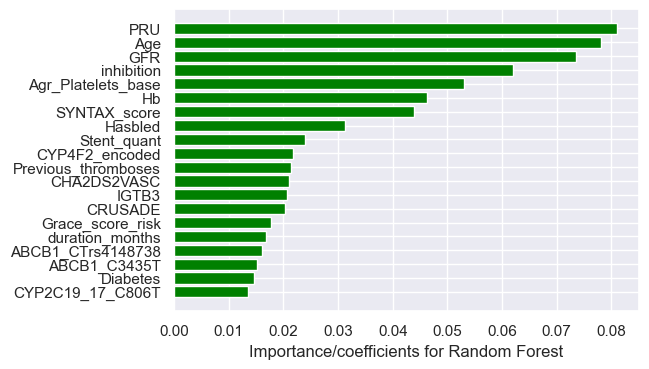

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[74 15]
 [12  2]]


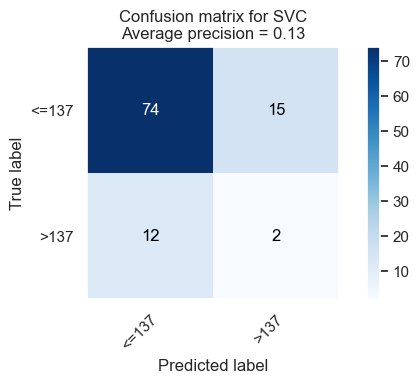

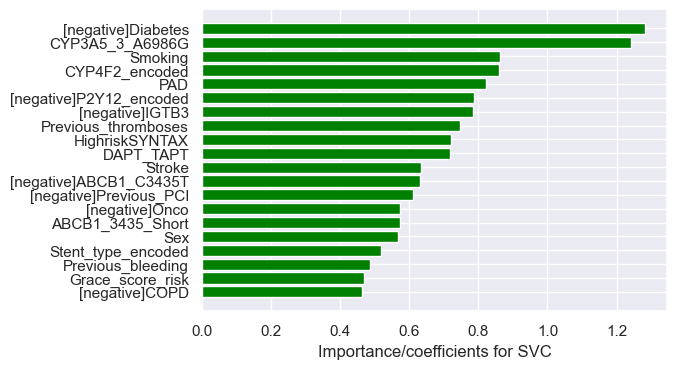

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[82  7]
 [14  0]]


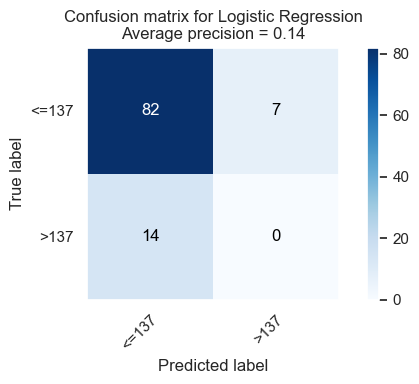

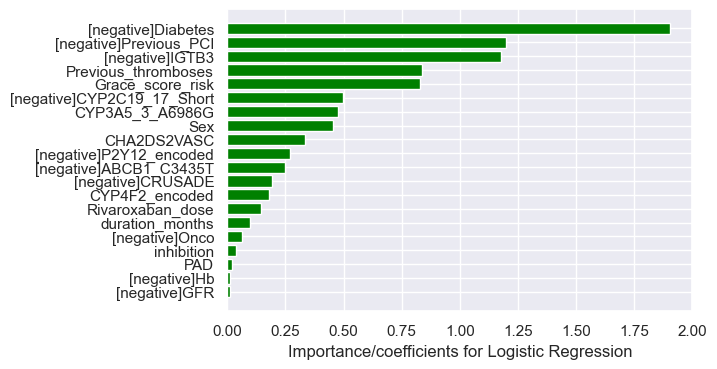

<Figure size 1000x700 with 0 Axes>

In [39]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## [Concentration higher/lower than 39] classification - using LOOCV

### Outcome column generation


In [40]:
df5 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes_c(row):
    if row.Rivaroxaban_C_blood <= 39 :
        outcome = '<=39'
    else:
        outcome = '>39'
    return outcome


df5['C_rivar_39_outcome'] = df.apply(
    process_row_outcomes_c,
    axis = 1
)
encoder = LabelEncoder()
df5['C_rivar_39_outcome_encoded'] = encoder.fit_transform(df5.C_rivar_39_outcome)

df5 = df5.drop([col for col in df5.columns if col.startswith('Outcome')] + ['Rivaroxaban_C_blood'], axis=1)

X = df5[[col for col in df5.columns if not col.startswith('C_rivar')]]
Y = df5['C_rivar_39_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

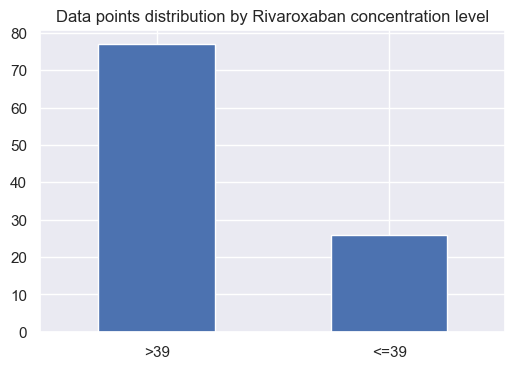

In [41]:
ax = df5.C_rivar_39_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Rivaroxaban concentration level')
plt.xticks(rotation=0)

In [42]:
df5.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score',
       'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB1_3435_Short',
       'ABCB1_rs4148738_Short', 'CYP2C19_2_Short', 'CYP2C19_17_Short', 'CES1',
       'CYP3A4_2242480', 'PON1', 'IGTB3', 'PEAR1_rs41273215',
       'AF

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[ 0 26]
 [ 6 71]]


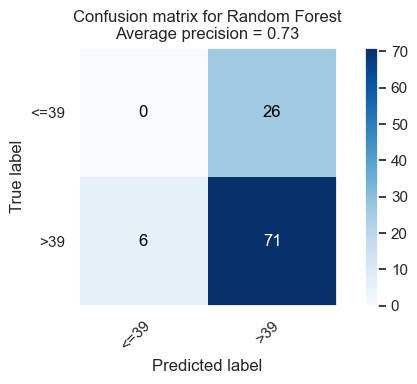

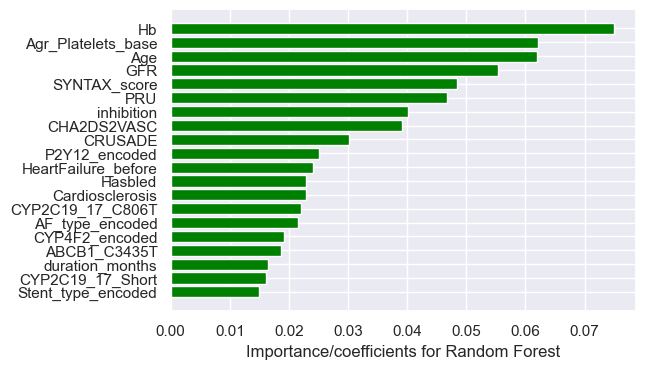

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[ 6 20]
 [22 55]]


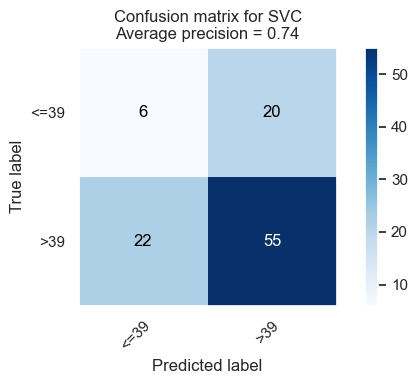

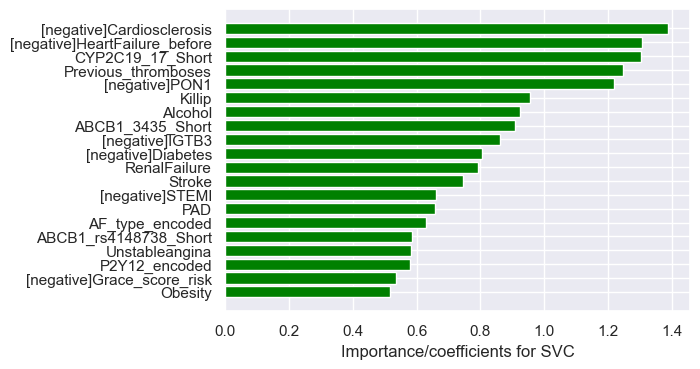

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[ 5 21]
 [16 61]]


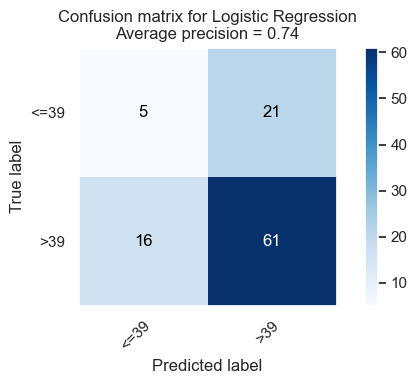

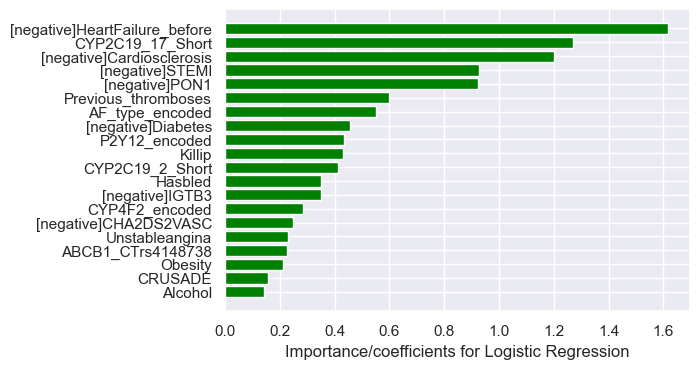

<Figure size 1000x700 with 0 Axes>

In [43]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## Survived/died Outcomes analysis

Text(0.5, 1.0, 'GFR grouped by outcome')

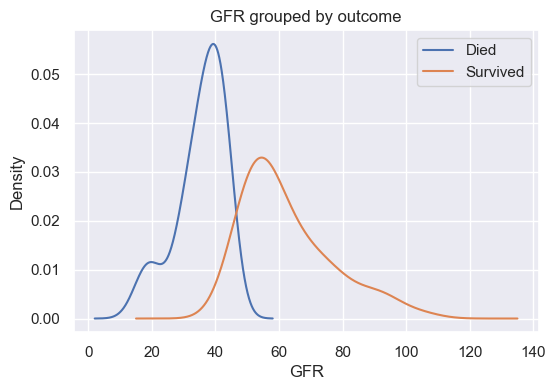

In [44]:
fig, ax = plt.subplots()
df2.groupby("Outcome").GFR.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('GFR')
ax.set_title('GFR grouped by outcome')

Text(0.5, 1.0, 'Age grouped by outcome')

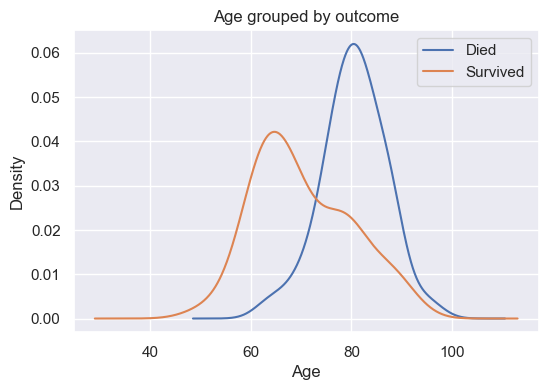

In [45]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Age.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Age')
ax.set_title('Age grouped by outcome')

Text(0.5, 1.0, 'Age/GFR grouped by outcome')

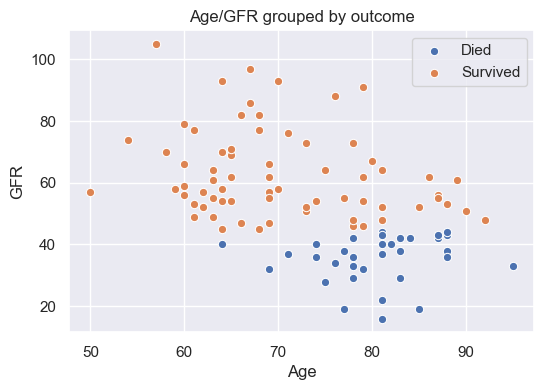

In [46]:
fig, ax = plt.subplots()
df_Age_GFR = df2[df2.Outcome_encoded == 0][['Age', 'GFR']]
sns.scatterplot(x='Age', y='GFR', data=df_Age_GFR)
df_Age_GFR = df2[df2.Outcome_encoded == 1][['Age', 'GFR']]
sns.scatterplot(x='Age', y='GFR', data=df_Age_GFR)
ax.legend(["Died", "Survived"])
ax.set_title('Age/GFR grouped by outcome')

Text(0.5, 1.0, 'CRUSADE grouped by outcome')

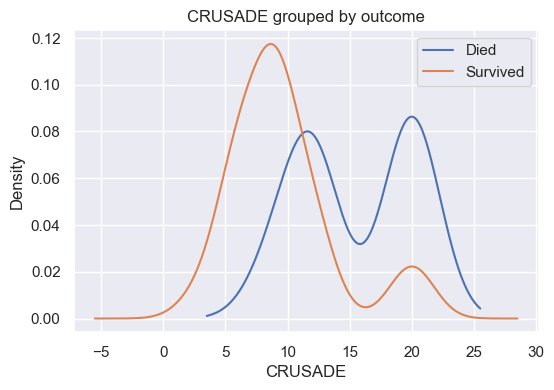

In [47]:
fig, ax = plt.subplots()
df2.groupby("Outcome").CRUSADE.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('CRUSADE')
ax.set_title('CRUSADE grouped by outcome')

Text(0.5, 1.0, 'SYNTAX_score grouped by outcome')

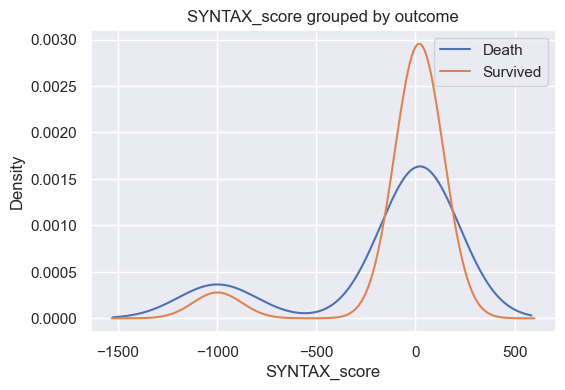

In [48]:
fig, ax = plt.subplots()
df2.groupby("Outcome").SYNTAX_score.plot(kind='kde')
ax.legend(["Death", "Survived"])
ax.set_xlabel('SYNTAX_score')
ax.set_title('SYNTAX_score grouped by outcome')

Text(0.5, 1.0, 'PRU grouped by outcome')

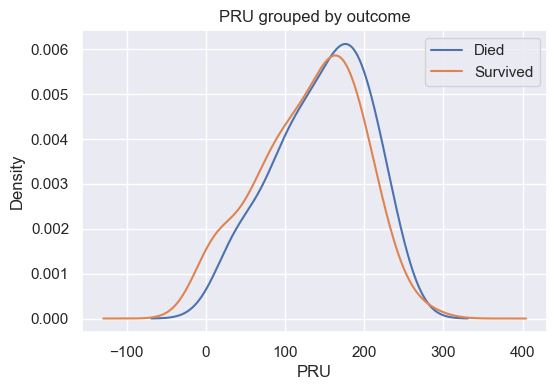

In [49]:
fig, ax = plt.subplots()
df2.groupby("Outcome").PRU.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('PRU')
ax.set_title('PRU grouped by outcome')

Text(0.5, 1.0, 'Hb grouped by outcome')

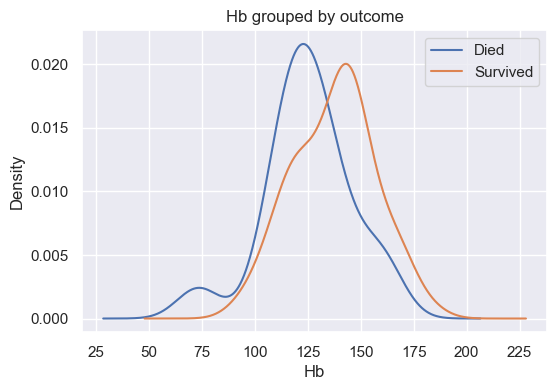

In [50]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Hb.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Hb')
ax.set_title('Hb grouped by outcome')


Text(0.5, 1.0, 'Rivaroxaban_C_blood grouped by outcome')

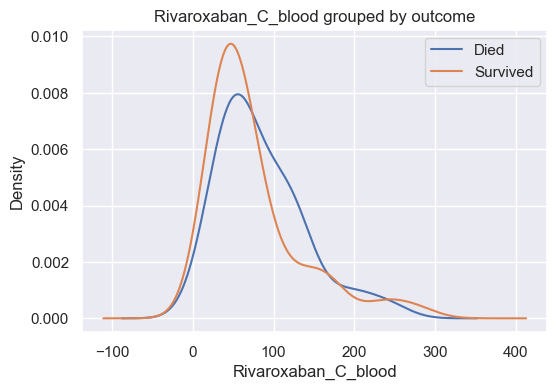

In [51]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Rivaroxaban_C_blood.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Rivaroxaban_C_blood')
ax.set_title('Rivaroxaban_C_blood grouped by outcome')

# Task number 2

Concentration prediction

Target column -> `Rivaroxaban_C_blood`

## Removing outcome and missing values columns 

In [52]:
df3 = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *SUSPICIOUS_MISSING_VALUES_COLUMNS,
            *AMBIGUOUS_COLUMNS,
            *['Outcome',]
        ]
    ]
]
df3 = df3.replace(' ', 0)

X_reg = df3[[col for col in df3.columns if not col in ['Rivaroxaban_C_blood', 'C_rivar_137']]]
# Leaving only numeric or binary columns
X_reg = X_reg[[col for col in X_reg.columns if col in [*NUMERIC_COLUMNS, *BINARY_VALUES_COLUMNS]]]
Y_reg = df3.Rivaroxaban_C_blood


## Compute baseline error - simple average prediction

In [53]:
from sklearn.metrics import mean_squared_error

Y_avg = np.full(Y_reg.shape[0], Y_reg.mean())
baseline_mse = mean_squared_error(Y_reg, Y_avg)
baseline_mse

3257.379583372608

## Validating models

In [49]:
regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]


In [50]:
def evaluate_regression_model(model, X, Y, model_name):
    kfold = KFold(n_splits=10)

    mse_s_over_folds = []
    predictions = []
    for train, test in kfold.split(X):
        Y_pred = model.fit(X.iloc[train], Y.iloc[train]).predict(X.iloc[test])
        mse_s_over_folds.append(mean_squared_error(Y.iloc[test], Y_pred))
        predictions.extend(Y_pred)
    ax = sns.lineplot(
        x=np.arange(0,10), y=mse_s_over_folds, 
    )
    ax.set_label(model_name)
    ax.set_title(f'MSE metric by folds')
    print(f'Resulting MSE for {model_name} is {sum(mse_s_over_folds)/10:.2f}')
    print(f'Resulting overall r_squared for {model_name} is {r2_score(Y, predictions):.2f}')
    return predictions

Resulting MSE for lasso alpha 1 is 4908.55
Resulting overall r_squared for lasso alpha 1 is -0.51
Resulting MSE for lasso alpha 100 is 3320.62
Resulting overall r_squared for lasso alpha 100 is -0.02
Resulting MSE for SVR is 4087.61
Resulting overall r_squared for SVR is -0.26
Resulting MSE for RF reg 2 50 is 3350.17
Resulting overall r_squared for RF reg 2 50 is -0.03
Resulting MSE for RF reg 4 100 is 3295.88
Resulting overall r_squared for RF reg 4 100 is -0.02
Resulting MSE for PLS 2 comp is 4362.57
Resulting overall r_squared for PLS 2 comp is -0.35
Resulting MSE for PLS 1 comp is 3652.77
Resulting overall r_squared for PLS 1 comp is -0.12


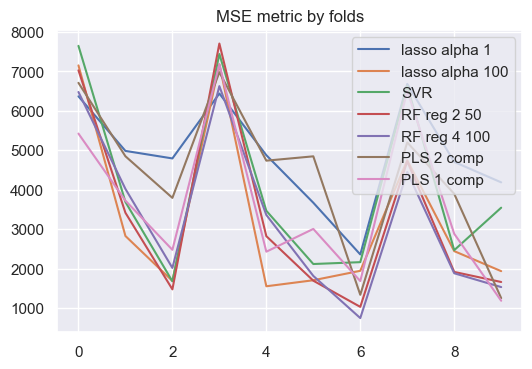

In [56]:
for model_name, model in regression_models:
    evaluate_regression_model(model, X_reg, Y_reg, model_name)
plt.legend([i[0] for i in regression_models])

In [57]:
X_reg.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'HighriskSYNTAX',
       'Grace_score_risk', 'CRUSADE', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'Rivaroxaban_dose', 'CYP3A4_22', 'CYP3A5_3_A6986G',
       'ABCB1_3435_Short', 'ABCB1_rs4148738_Short', 'CYP2C19_2_Short',
       'CYP2C19_17_Short', 'CES1', 'CYP3A4_2242480', 'PON1', 'IGTB3',
       'PEAR1_rs41273215'],
      dtype='object')

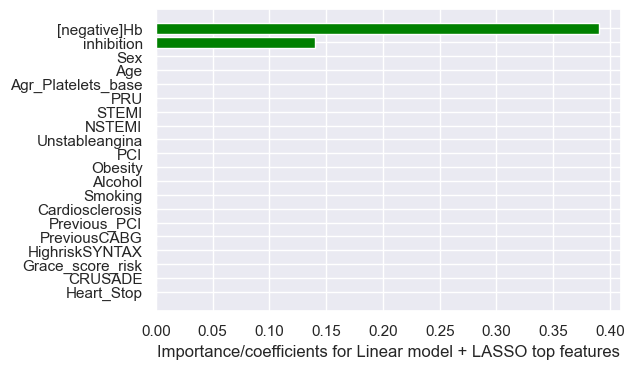

<Figure size 1000x700 with 0 Axes>

In [58]:
lasso_reg = linear_model.Lasso(alpha=100, random_state=random_state)
lasso_reg.fit(X_reg, Y_reg)
plot_important_features(X_reg, lasso_reg.coef_, 'Linear model + LASSO top features')


## Using PCA to reduce dimensions 

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_reg))

Resulting MSE for lasso alpha 1 is 3385.99
Resulting overall r_squared for lasso alpha 1 is -0.05
Resulting MSE for lasso alpha 100 is 3326.92
Resulting overall r_squared for lasso alpha 100 is -0.03
Resulting MSE for SVR is 3717.72
Resulting overall r_squared for SVR is -0.15
Resulting MSE for RF reg 2 50 is 3499.79
Resulting overall r_squared for RF reg 2 50 is -0.08
Resulting MSE for RF reg 4 100 is 3840.25
Resulting overall r_squared for RF reg 4 100 is -0.18
Resulting MSE for PLS 2 comp is 3386.68
Resulting overall r_squared for PLS 2 comp is -0.05
Resulting MSE for PLS 1 comp is 3389.08
Resulting overall r_squared for PLS 1 comp is -0.05


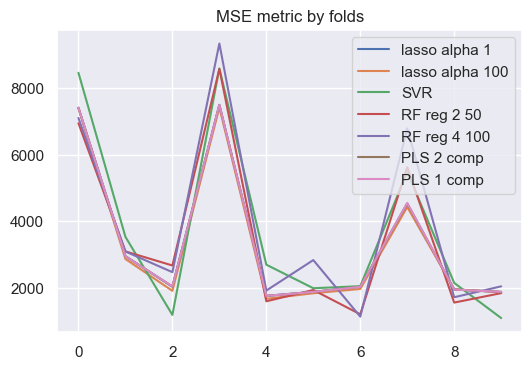

In [60]:
results = {}
for model_name, model in regression_models:
    predictions = evaluate_regression_model(model, X_pca, Y_reg, model_name)
    results[model_name] = predictions
plt.legend([i[0] for i in regression_models])

In [61]:
pca1 = PCA(n_components=1)
X_pca1 = pd.DataFrame(pca1.fit_transform(X_reg))

Resulting MSE for lasso alpha 1 is 3436.82
Resulting overall r_squared for lasso alpha 1 is -0.06
Resulting MSE for lasso alpha 100 is 3373.34
Resulting overall r_squared for lasso alpha 100 is -0.04
Resulting MSE for SVR is 3807.99
Resulting overall r_squared for SVR is -0.17
Resulting MSE for RF reg 2 50 is 3570.03
Resulting overall r_squared for RF reg 2 50 is -0.11
Resulting MSE for RF reg 4 100 is 3990.94
Resulting overall r_squared for RF reg 4 100 is -0.23


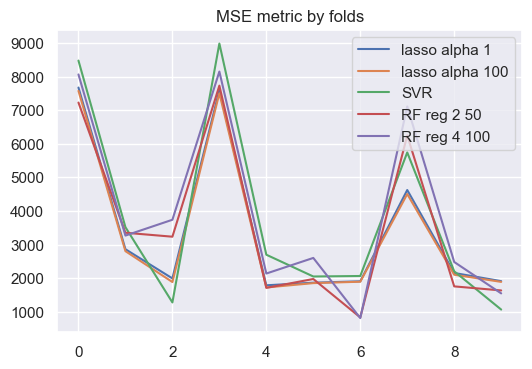

In [62]:
results = {}
for model_name, model in regression_models[:-2]:
    predictions = evaluate_regression_model(model, X_pca1, Y_reg, model_name)
    results[model_name] = predictions
plt.legend([i[0] for i in regression_models])

## Regression Summary:
All models trained both using raw dataset and PCA showed worse performance than simply predicting average all the time

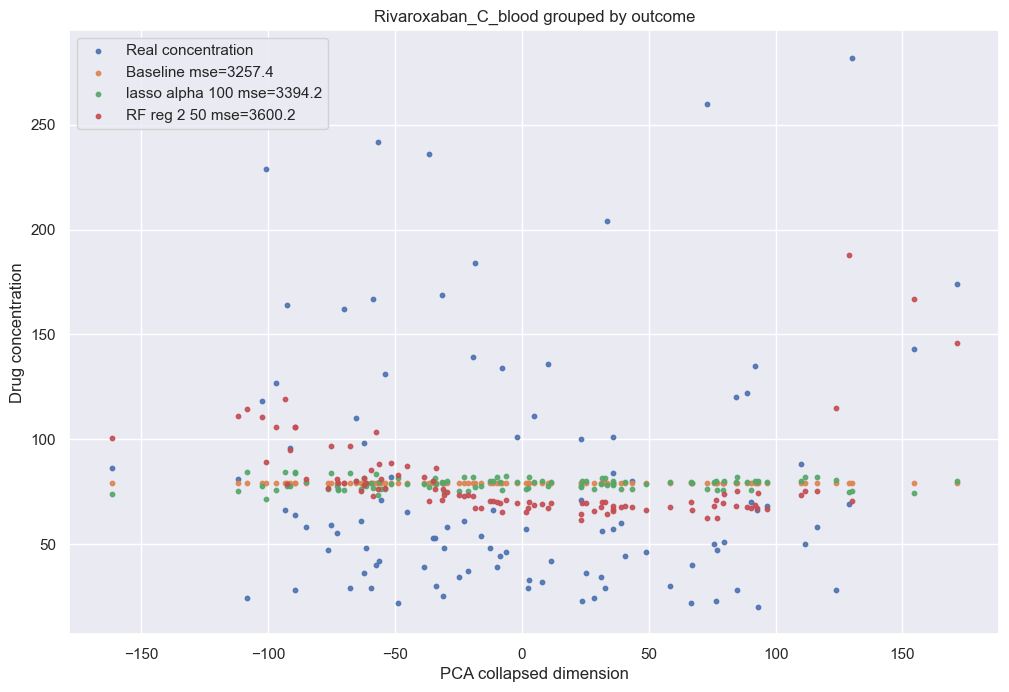

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
plt.scatter(X_pca1, Y_reg, alpha=0.9, s=10)
plt.scatter(X_pca1, Y_avg, alpha=0.9, s=10)
# plt.scatter(X_pca1, results['RF reg 2 50'], alpha=0.9, s=10)

legend = [
    'Real concentration',
    f'Baseline mse={baseline_mse:.1f}',
]
for model in ['lasso alpha 100', 'RF reg 2 50']:
    plt.scatter(X_pca1, results[model], alpha=0.9, s=10)
    mse = mean_squared_error(results[model], Y_reg)
    legend.append(f'{model} mse={mse:.1f}')

ax.set_xlabel('PCA collapsed dimension')
ax.set_ylabel('Drug concentration')
ax.set_title('Rivaroxaban_C_blood grouped by outcome')
plt.legend(legend)



In [64]:
## Visualize errors distribution

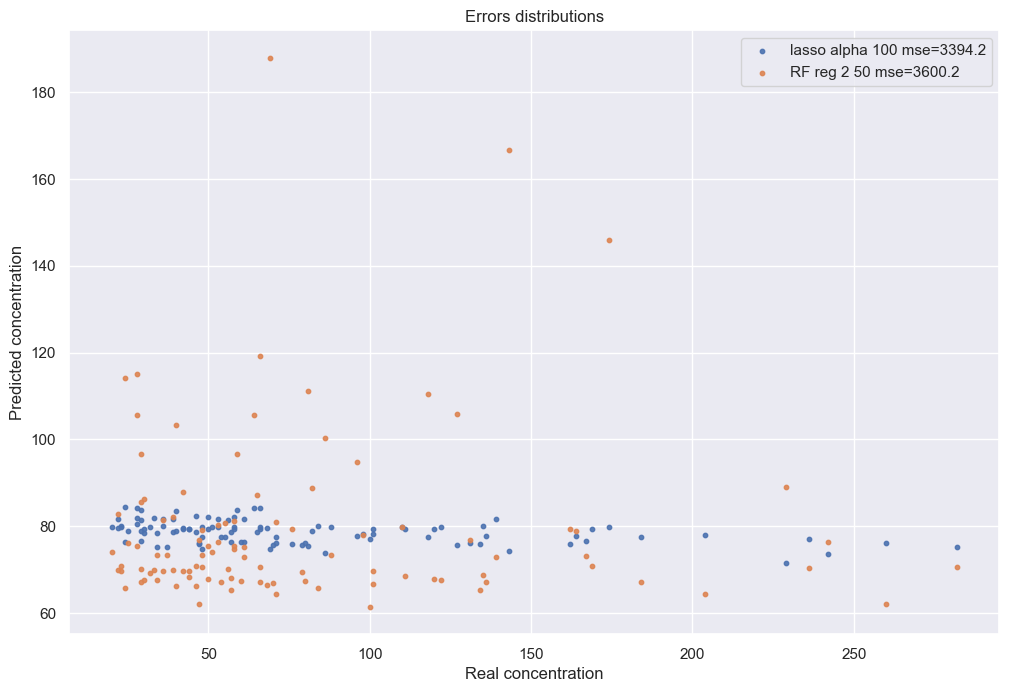

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
# plt.scatter(Y_avg, Y_reg, alpha=0.9, s=10)

legend = [
#     f'Baseline mse={baseline_mse:.1f}',
]
for model in ['lasso alpha 100', 'RF reg 2 50']:
    plt.scatter(Y_reg, results[model], alpha=0.9, s=10)
    mse = mean_squared_error(results[model], Y_reg)
    legend.append(f'{model} mse={mse:.1f}')

ax.set_ylabel('Predicted concentration')
ax.set_xlabel('Real concentration')
ax.set_title('Errors distributions')
plt.legend(legend)



## Visualize dots using 2-dimensional PCA

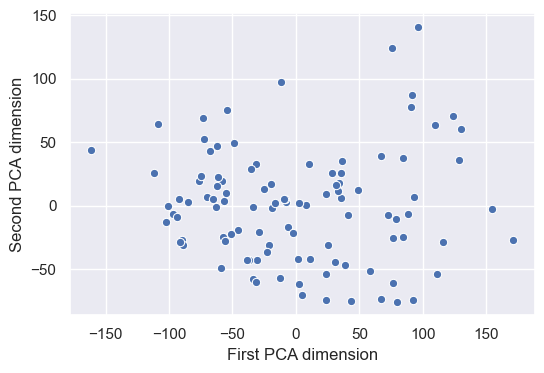

In [66]:
X_pca.columns = ['First PCA dimension', 'Second PCA dimension']
ax = sns.scatterplot(x='First PCA dimension', y='Second PCA dimension', data=X_pca)

In [67]:
df_vars = pd.DataFrame(pca.components_, columns=X_reg.columns, index=['PC-1','PC-2'])
df_vars

Sex       Age  Agr_Platelets_base  inhibition       PRU     STEMI  \
PC-1 -0.000911 -0.028742           -0.367024    0.303762 -0.873784 -0.001098   
PC-2  0.002874  0.053779            0.868158    0.379076 -0.254453  0.000945   

        NSTEMI  Unstableangina       PCI   Obesity  ...  CYP3A5_3_A6986G  \
PC-1  0.000064        0.000960 -0.000071  0.000707  ...         0.000286   
PC-2 -0.000676       -0.000486 -0.000885 -0.001601  ...        -0.000797   

      ABCB1_3435_Short  ABCB1_rs4148738_Short  CYP2C19_2_Short  \
PC-1         -0.000037              -0.001084        -0.000474   
PC-2          0.000652               0.000966        -0.000897   

      CYP2C19_17_Short      CES1  CYP3A4_2242480      PON1     IGTB3  \
PC-1          0.001205  0.000766       -0.000570 -0.000134 -0.000253   
PC-2          0.002295  0.000582        0.000407  0.000354  0.001515   

      PEAR1_rs41273215  
PC-1          0.000424  
PC-2         -0.000955  

[2 rows x 51 columns]

## Figure out optimal alpha for LASSO using GridSearchCV


In [68]:
tuned_parameters = [{'alpha': np.arange(10, 1010, 10)}]
clf = GridSearchCV(
    linear_model.Lasso(alpha=1, random_state=random_state),
    tuned_parameters,
    cv=5,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)
clf.fit(X_reg, Y_reg,)
clf.best_params_

{'alpha': 590}

Resulting MSE for Lasso with huge alpha is 3305.74
Resulting overall r_squared for Lasso with huge alpha is -0.02


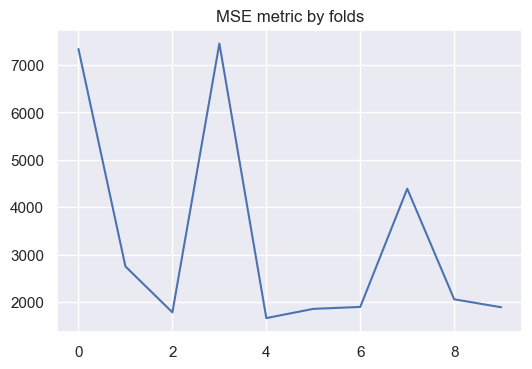

In [69]:
lasso_huge_alpha = linear_model.Lasso(alpha=590, random_state=random_state)
_ = evaluate_regression_model(
    lasso_huge_alpha,
    X_reg,
    Y_reg,
    'Lasso with huge alpha'
)

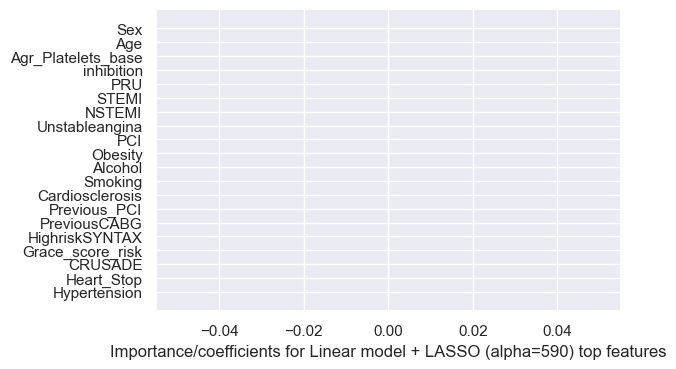

<Figure size 1000x700 with 0 Axes>

In [70]:
plot_important_features(X_reg, lasso_huge_alpha.coef_, 'Linear model + LASSO (alpha=590) top features')


In [71]:
lasso_huge_alpha.coef_

array([ 0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.])

Looks like the smallest mse is shown, when all predictions are zeroes.

# Clopidogrel analysis

## Read and preprocess data

In [26]:
clopidogrel_genetics_df = pd.read_csv(
    'Clopidogrel_genetics.csv'
).rename(columns={
    '№': 'Number', 'пол': 'gender', 'возраст': 'age', 'Клопи концентрация, нг/мл': 'Concentration'
}).set_index('Number')
INSIGNIFICANT_CONCENTRATION_THRESHOLD = .25


In [27]:
import re
PATTERN = '[^a-zA-Z0-9а-яА-Я -]'

clopidogrel_genetics_df.columns = [re.sub(PATTERN, '', re.sub('[\n ]+', ' ', col)) for col in clopidogrel_genetics_df.columns]
clopidogrel_genetics_df.columns

Index(['gender', 'age', 'ABCB1 С3435Т', ' CYP3A53 A6986G', 'CYP3A422 CT',
       'ABCB1 СТ rs4148738', 'CYP2C192 G681A', 'CYP2C193 G636A',
       'CYP2C1917 C-806T', 'CYP4F2 CVal433MetT ', 'CES1 А-33С rs2244613',
       'CYP3A4 rs2242480', 'PON1 rs662', 'IGTB3 rs5918', 'P2Y12 rs2046934',
       'Новый rs80343429 GA ', 'PEAR1 rs822442 CA', 'PEAR1 rs41273215 CТ',
       'PEAR1 rs57731889 CT', 'P2Y12R rs3732759 AG', 'B4GALT2 rs1061781 CТ',
       'ABCG2 rs2231142 GT', 'CYP2B6 rs2279343 A  G', 'Concentration'],
      dtype='object')

In [28]:
genetics_df_cols_values = pd.Series({col: clopidogrel_genetics_df[col].unique() for col in clopidogrel_genetics_df.columns})
genetics_df_cols_values

gender                                                          [жен, муж]
age                      [81, 88, 73, 61, 78, 71, 58, 87, 65, 95, 62, 6...
ABCB1 С3435Т                                              [CC, СT, CT, TT]
 CYP3A53 A6986G                                                   [GG, AG]
CYP3A422 CT                                                   [СС, CC, CT]
ABCB1 СТ rs4148738                                        [TT, CT, CC, СТ]
CYP2C192 G681A                                                [GG, GA, AA]
CYP2C193 G636A                                                        [GG]
CYP2C1917 C-806T                                              [CT, CC, TT]
CYP4F2 CVal433MetT                                            [CT, CC, TT]
CES1 А-33С rs2244613                                          [AA, AC, CC]
CYP3A4 rs2242480                                                  [GG, GA]
PON1 rs662                                                   [TT , CT, CC]
IGTB3 rs5918             

In [29]:


NON_GENETICS_COLUMNS = ['gender', 'age']
CONCENTRATION_COLUMN = 'Concentration'
MORE_THAN_2_VALUES_COLUMNS = genetics_df_cols_values.drop(
    index=NON_GENETICS_COLUMNS+[CONCENTRATION_COLUMN]
).index[genetics_df_cols_values.drop(index=NON_GENETICS_COLUMNS+[CONCENTRATION_COLUMN]).map(lambda x: len(x) > 2)]
SINGLE_VALUE_GENETICS_COLS = genetics_df_cols_values.index[genetics_df_cols_values.map(lambda x: len(x) == 1)]
SINGLE_VALUE_GENETICS_COLS
TWO_VALUES_COLS = genetics_df_cols_values.index[genetics_df_cols_values.map(lambda x: len(x) == 2)]

In [30]:
SINGLE_VALUE_GENETICS_COLS

Index(['CYP2C193 G636A', 'Новый rs80343429 GA '], dtype='object')

In [31]:
clopidogrel_genetics_df.drop(columns=SINGLE_VALUE_GENETICS_COLS, inplace=True)

In [32]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_column(column: pd.Series) -> pd.DataFrame:
    col_array = column.to_numpy().reshape(-1,1)
    encoder = OneHotEncoder(sparse=False).fit(col_array)
    categories = encoder.categories_[0]
    result = pd.DataFrame(encoder.transform(col_array), columns=[column.name + f' is {cat}' for cat in categories], index=column.index)
    return result

In [33]:
processed_clop_genetics_df = clopidogrel_genetics_df.drop(columns=MORE_THAN_2_VALUES_COLUMNS).copy()
for col in MORE_THAN_2_VALUES_COLUMNS:
    processed_clop_genetics_df = pd.merge(
        processed_clop_genetics_df, one_hot_encode_column(clopidogrel_genetics_df[col]), left_index=True, right_index=True
    )
    

processed_clop_genetics_df[
    'Concentration'
] = clopidogrel_genetics_df[CONCENTRATION_COLUMN].replace(
    'НПКО', 0
).replace('Нет данных', 'NaN').str.replace(',', '.').astype(float)
processed_clop_genetics_df['Concentration'] = processed_clop_genetics_df['Concentration'].map(
lambda x: 0 if x <INSIGNIFICANT_CONCENTRATION_THRESHOLD else x
)



processed_clop_genetics_df.rename(
    inplace=True, columns={'пол': 'gender', 'возраст': 'age'}
)
processed_clop_genetics_df['gender'] = processed_clop_genetics_df['gender'].map(
    {'жен': 'female', 'муж': 'male'}
)

for category_col in TWO_VALUES_COLS:
    encoder = LabelEncoder()
    processed_clop_genetics_df[category_col + '_encoded'] = encoder.fit_transform(
        processed_clop_genetics_df[category_col]
    )
processed_clop_genetics_df = processed_clop_genetics_df.drop(
    columns=TWO_VALUES_COLS)

processed_clop_genetics_df

age  Concentration  ABCB1 С3435Т is CC  ABCB1 С3435Т is CT  \
Number                                                               
1        81           4.95                 1.0                 0.0   
2        88            NaN                 0.0                 0.0   
3        81           0.60                 0.0                 1.0   
4        73           7.02                 0.0                 1.0   
5        61          15.99                 0.0                 1.0   
...     ...            ...                 ...                 ...   
99       77           3.96                 1.0                 0.0   
100      60           2.66                 1.0                 0.0   
101      60           2.58                 0.0                 1.0   
102      76           3.02                 1.0                 0.0   
103      74           0.36                 1.0                 0.0   

        ABCB1 С3435Т is TT  ABCB1 С3435Т is СT  CYP3A422 CT is CC  \
Number                                                              
1                      0.0                 0.0                0.0   
2                      0.0                 1.0                0.0   
3                      0.0                 0.0                0.0   
4                      0.0                 0.0                0.0   
5                      0.0                 0.0                0.0   
...                    ...                 ...                ...   
99                     0.0                 0.0                1.0   
100                    0.0                 0.0                0.0   
101                    0.0                 0.0                1.0   
102                    0.0                 0.0                1.0   
103                    0.0                 0.0                1.0   

        CYP3A422 CT is CT  CYP3A422 CT is СС  ABCB1 СТ rs4148738 is CC  ...  \
Number                                                                  ...   
1                     0.0                1.0                       0.0  ...   
2                     0.0                1.0                       0.0  ...   
3                     0.0                1.0                       0.0  ...   
4                     0.0                1.0                       0.0  ...   
5                     0.0                1.0                       0.0  ...   
...                   ...                ...                       ...  ...   
99                    0.0                0.0                       0.0  ...   
100                   1.0                0.0                       0.0  ...   
101                   0.0                0.0                       0.0  ...   
102                   0.0                0.0                       0.0  ...   
103                   0.0                0.0                       0.0  ...   

        P2Y12R rs3732759 AG is AA  P2Y12R rs3732759 AG is AG  \
Number                                                         
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             1.0                        0.0   
4                             1.0                        0.0   
5                             1.0                        0.0   
...                           ...                        ...   
99                            0.0                        1.0   
100                           1.0                        0.0   
101                           1.0                        0.0   
102                           0.0                        1.0   
103                           0.0                        1.0   

        P2Y12R rs3732759 AG is GG  gender_encoded   CYP3A53 A6986G_encoded  \
Number                                                                       
1                             1.0               0                        1   
2                             1.0               0                        1   
3                         

In [34]:
processed_clop_genetics_df['Concentration'].isna().sum()

9

## Formatting outcome columns

In [42]:
rivaroxaban_raw_df = df.copy()
rivaroxaban_raw_df.index = rivaroxaban_raw_df.index.astype('int')
rivaroxaban_preprocessed_df = preprocessed_classification_df.copy()
rivaroxaban_preprocessed_df.index = rivaroxaban_preprocessed_df.index.astype('int')

In [43]:
Y_clop_concentration = processed_clop_genetics_df['Concentration']
Y_PRU = df['PRU']
Y_PRU.index = processed_clop_genetics_df.index
Y_death_survived_outcomes_series = rivaroxaban_raw_df.apply(
    process_row_outcomes_survived,
    axis = 1
)


## Outcomes classification using all columns from both sources

################################### Random Forest ###################################
Confusion matrix, without normalization
[[28  3]
 [ 1 62]]


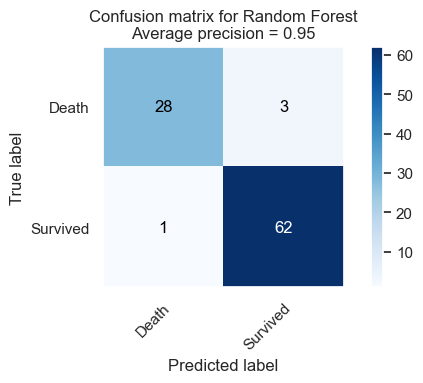

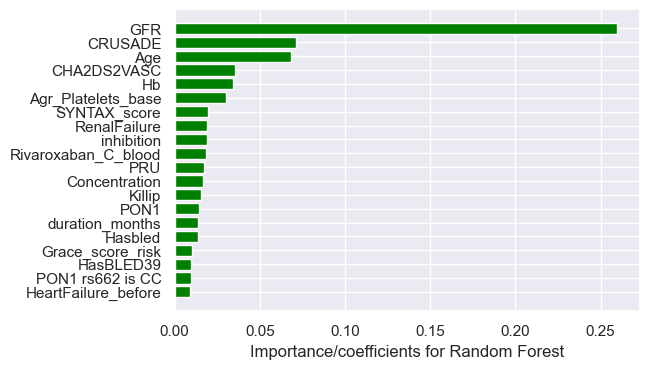

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[27  4]
 [ 4 59]]


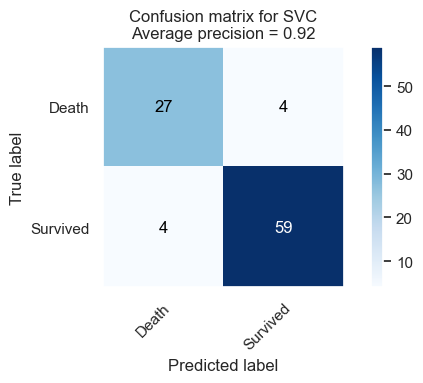

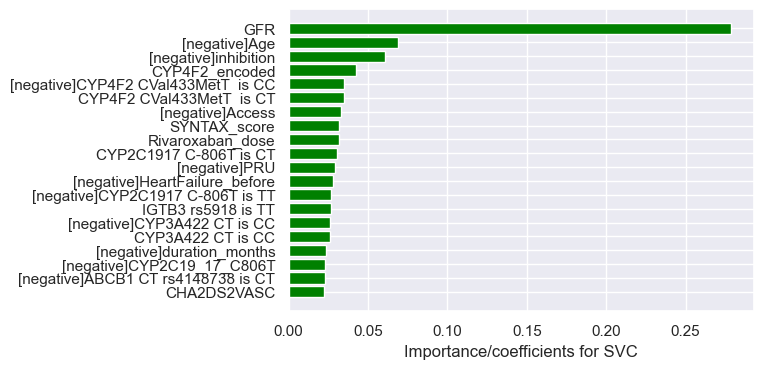

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Confusion matrix, without normalization
[[29  2]
 [ 2 61]]


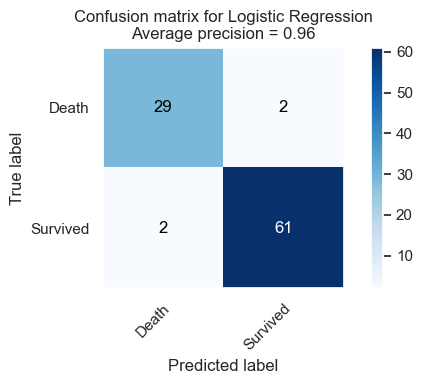

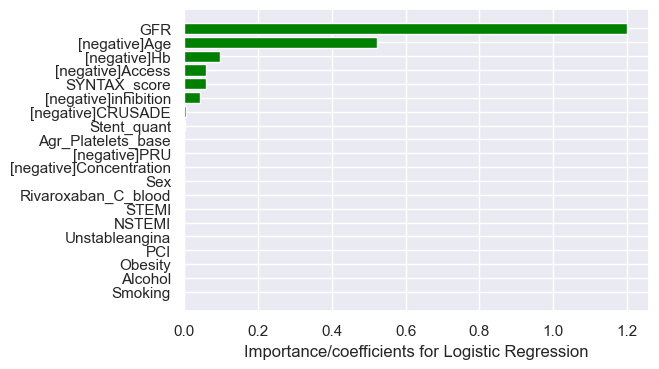

<Figure size 1000x700 with 0 Axes>

In [83]:

X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['age'])
encoder = LabelEncoder()
Y = pd.Series(
    encoder.fit_transform(Y_death_survived_outcomes_series[X.index]),
    index=X.index
)

CLASS_NAMES = encoder.classes_

rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## Predicting outcomes using only clopidogrel data

################################### Random Forest ###################################
Confusion matrix, without normalization
[[10 21]
 [ 7 56]]


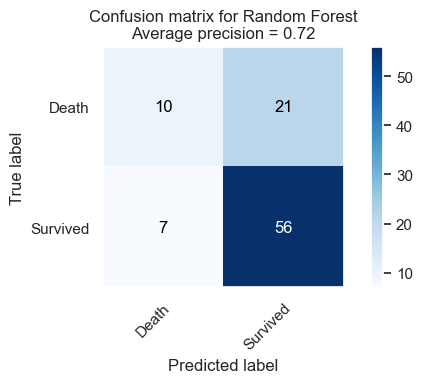

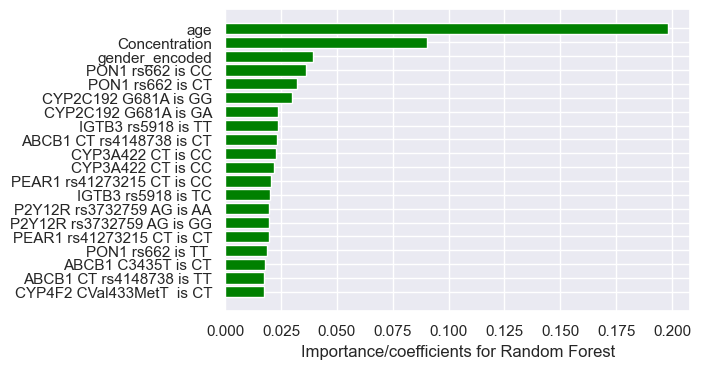

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[15 16]
 [13 50]]


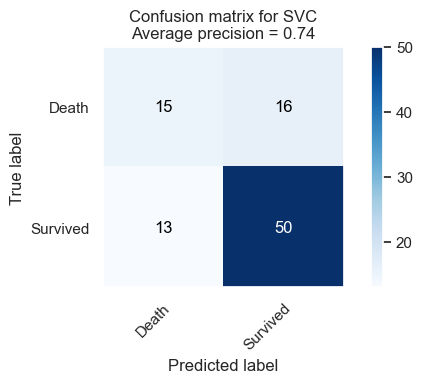

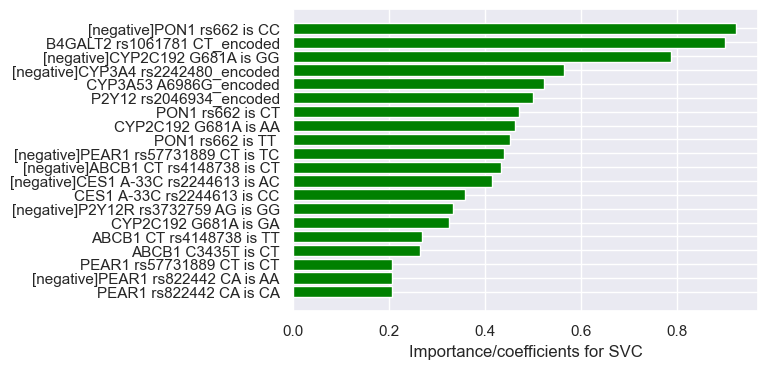

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[10 21]
 [10 53]]


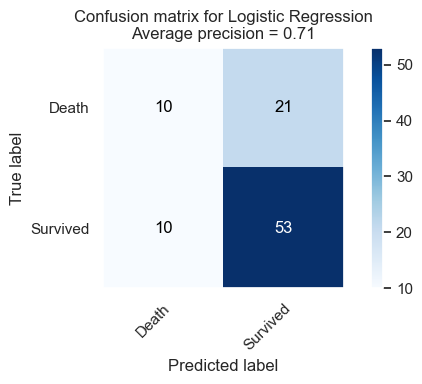

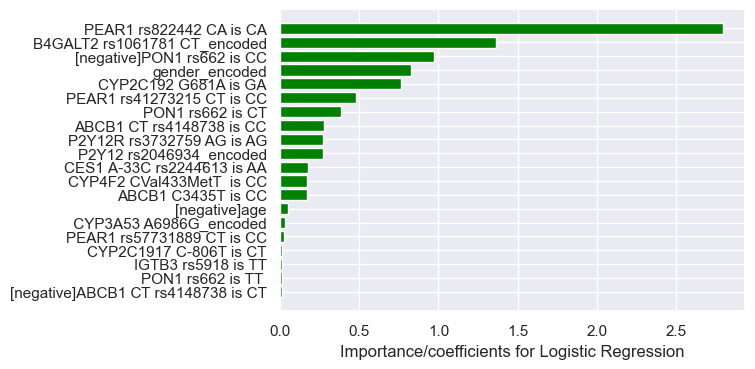

<Figure size 1000x700 with 0 Axes>

In [84]:
X = processed_clop_genetics_df.dropna()
encoder = LabelEncoder()
Y = pd.Series(
    encoder.fit_transform(Y_death_survived_outcomes_series[X.index]),
    index=X.index
)

CLASS_NAMES = encoder.classes_

rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

## PRU regression - All columns from both data sources

In [44]:
def dotplot(Y, Y_pred, model_name, label):
    plt.scatter(Y, Y, color='red',marker='^', alpha=0.5, label='Actual')
    mse = mean_squared_error(Y, Y_pred)
    plt.scatter(Y, Y_pred, label='Predicted', alpha=.5, color='green')
    plt.title(f'{label} - {model_name}. MSE: {mse:.2f}')
    plt.xlabel('Y True')
    plt.ylabel('Y Pred')
    plt.show()

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77594.92411358848, tolerance: 32.488895238095246
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76823.6344993797, tolerance: 30.119057142857148
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79653.48309316928, tolerance: 29.935441666666666
  model = cd_fast.enet_coordinate_descent(
/U

Resulting MSE for lasso alpha 1 is 4605.38
Resulting overall r_squared for lasso alpha 1 is -0.26
Resulting MSE for lasso alpha 100 is 3549.73
Resulting overall r_squared for lasso alpha 100 is 0.03
Resulting MSE for lasso alpha 200 is 3720.58
Resulting overall r_squared for lasso alpha 200 is -0.02
Resulting MSE for SVR is 3699.04
Resulting overall r_squared for SVR is -0.00
Resulting MSE for RF reg 2 50 is 3873.95
Resulting overall r_squared for RF reg 2 50 is -0.06
Resulting MSE for RF reg 4 100 is 4001.67
Resulting overall r_squared for RF reg 4 100 is -0.10
Resulting MSE for PLS 2 comp is 4365.29
Resulting overall r_squared for PLS 2 comp is -0.20
Resulting MSE for PLS 1 comp is 4019.74
Resulting overall r_squared for PLS 1 comp is -0.11


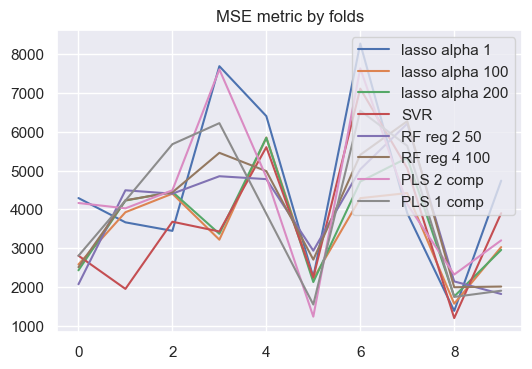

In [51]:
X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['PRU', 'inhibition', 'Agr_Platelets_base'])
encoder = LabelEncoder()
Y = Y_PRU[X.index]


Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
PRU_all_cols_regr_models = regression_models

In [52]:
rivaroxaban_preprocessed_df.columns

Index(['Sex', 'Age', 'Rivaroxaban_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'STEMI', 'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol',
       'Smoking', 'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score',
       'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB1_3435_Short',
       'ABCB1_rs4148738_Short', 'CYP2C19_2_Short', 'CYP2C19_17_Short', 'CES1',
       'CYP3A4_2242480', 'PON1', 'IGTB3', 'PEAR1_

### Predictions analysis

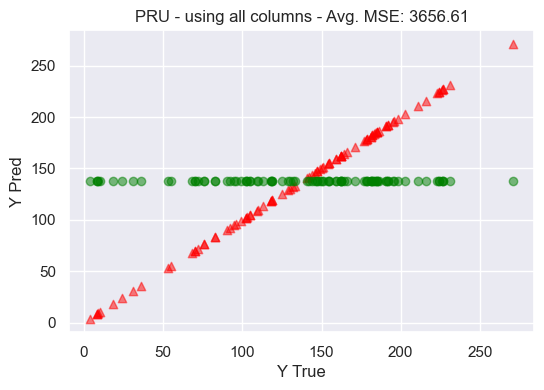

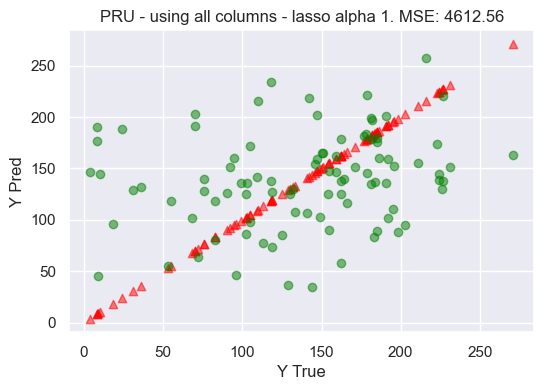

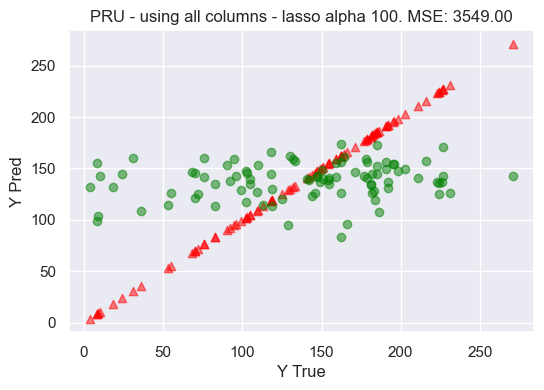

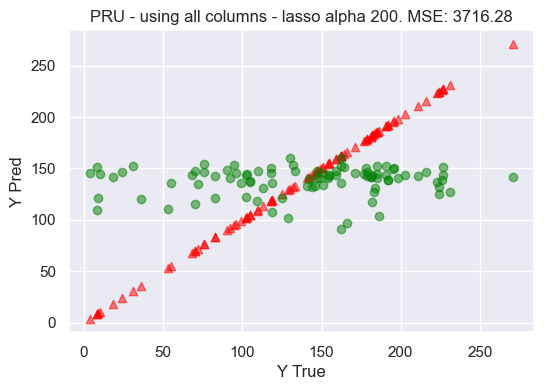

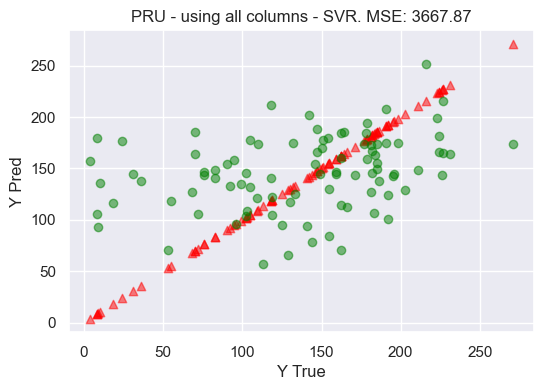

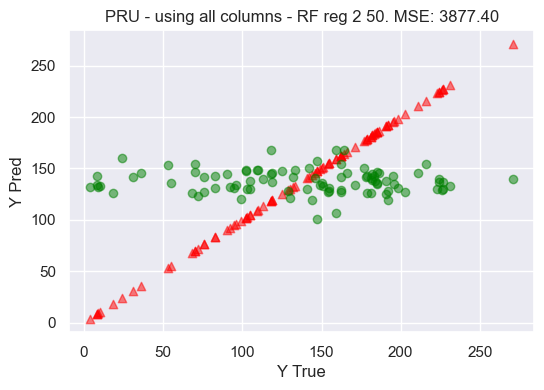

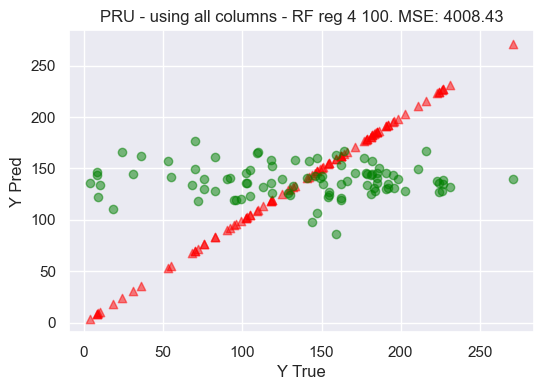

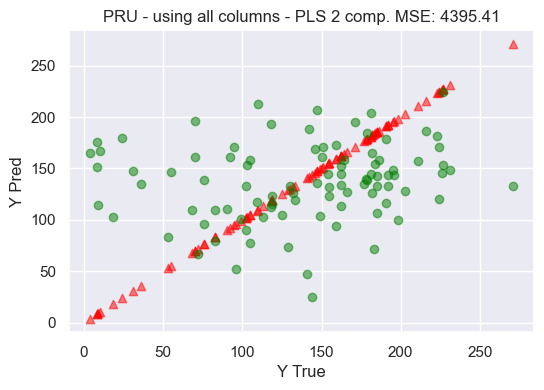

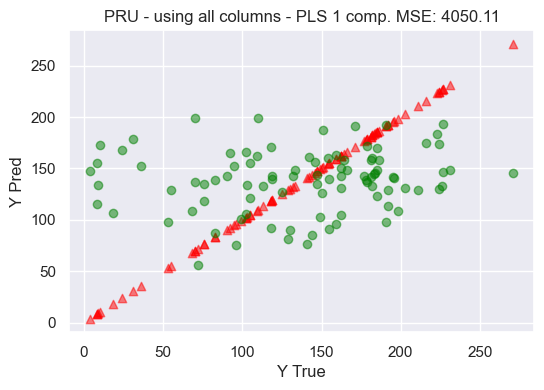

In [53]:
pred_label = 'PRU - using all columns'
for model in preds:
    dotplot(Y, preds[model], model, pred_label)

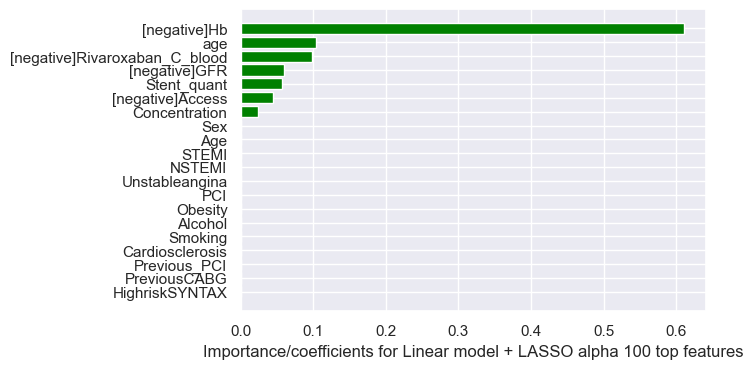

<Figure size 1000x700 with 0 Axes>

In [54]:
plot_important_features(X, dict(regression_models)['lasso alpha 100'].coef_, 'Linear model + LASSO alpha 100 top features')


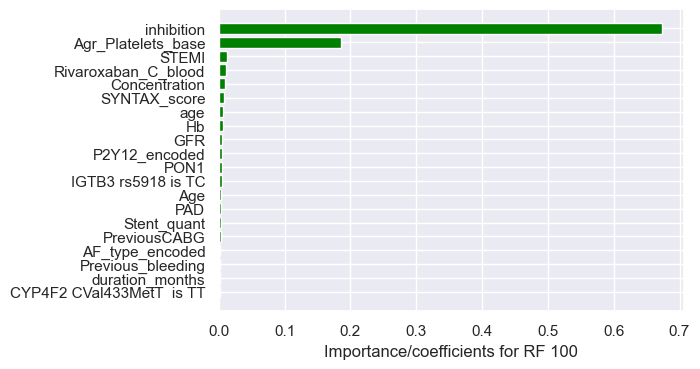

<Figure size 1000x700 with 0 Axes>

In [89]:
plot_important_features(X, dict(regression_models)['RF reg 4 100'].feature_importances_, 'RF 100')

## PRU regression - Only selected columns from both data sources

In [90]:
GENETICS_COLS = [ 'CYP3A4_22',
 'ABCB1_С3435Т',
 'ABCB1_СТrs4148738',
 'CYP2C19_2_G681A',
 'CYP2C19_17_C806T',
 'CYP3A5_3_A6986G',
 'ABCB1_3435_Short',
 'ABCB1_rs4148738_Short',
 'CYP2C19_2_Short',
 'CYP2C19_17_Short',
 'CES1',
 'CYP3A4_2242480',
 'PON1',
 'IGTB3',
 'PEAR1_rs41273215',
'CYP4F2_encoded',
 'P2Y12_encoded',
 'ABCB1 С3435Т is CC',
 'ABCB1 С3435Т is CT',
 'ABCB1 С3435Т is TT',
 'ABCB1 С3435Т is СT',
 'CYP3A422 CT is CC',
 'CYP3A422 CT is CT',
 'CYP3A422 CT is СС',
 'ABCB1 СТ rs4148738 is CC',
 'ABCB1 СТ rs4148738 is CT',
 'ABCB1 СТ rs4148738 is TT',
 'ABCB1 СТ rs4148738 is СТ',
 'CYP2C192 G681A is AA',
 'CYP2C192 G681A is GA',
 'CYP2C192 G681A is GG',
 'CYP2C1917 C-806T is CC',
 'CYP2C1917 C-806T is CT',
 'CYP2C1917 C-806T is TT',
 'CYP4F2 CVal433MetT  is CC',
 'CYP4F2 CVal433MetT  is CT',
 'CYP4F2 CVal433MetT  is TT',
 'CES1 А-33С rs2244613 is AA',
 'CES1 А-33С rs2244613 is AC',
 'CES1 А-33С rs2244613 is CC',
 'PON1 rs662 is CC',
 'PON1 rs662 is CT',
 'PON1 rs662 is TT ',
 'IGTB3 rs5918 is CC',
 'IGTB3 rs5918 is TC',
 'IGTB3 rs5918 is TT',
 'PEAR1 rs822442 CA is AA',
 'PEAR1 rs822442 CA is CA',
 'PEAR1 rs822442 CA is CC',
 'PEAR1 rs41273215 CТ is CC',
 'PEAR1 rs41273215 CТ is CT',
 'PEAR1 rs41273215 CТ is TT',
 'PEAR1 rs57731889 CT is CC',
 'PEAR1 rs57731889 CT is CT',
 'PEAR1 rs57731889 CT is TC',
 'PEAR1 rs57731889 CT is TT',
 'P2Y12R rs3732759 AG is AA',
 'P2Y12R rs3732759 AG is AG',
 'P2Y12R rs3732759 AG is GG',
 ' CYP3A53 A6986G_encoded',
 'CYP3A4 rs2242480_encoded',
 'P2Y12 rs2046934_encoded',
 'B4GALT2 rs1061781 CТ_encoded',
 'ABCG2 rs2231142 GT_encoded',
 'CYP2B6 rs2279343 A  G_encoded']

Resulting MSE for lasso alpha 1 is 4802.89
Resulting overall r_squared for lasso alpha 1 is -0.25
Resulting MSE for lasso alpha 100 is 3693.50
Resulting overall r_squared for lasso alpha 100 is 0.03
Resulting MSE for lasso alpha 200 is 3681.66
Resulting overall r_squared for lasso alpha 200 is 0.04
Resulting MSE for SVR is 4034.70
Resulting overall r_squared for SVR is -0.05
Resulting MSE for RF reg 2 50 is 4042.36
Resulting overall r_squared for RF reg 2 50 is -0.06
Resulting MSE for RF reg 4 100 is 4066.32
Resulting overall r_squared for RF reg 4 100 is -0.06
Resulting MSE for PLS 2 comp is 4593.75
Resulting overall r_squared for PLS 2 comp is -0.20
Resulting MSE for PLS 1 comp is 3957.14
Resulting overall r_squared for PLS 1 comp is -0.04


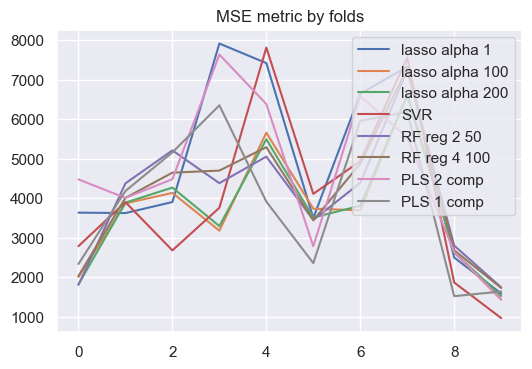

In [91]:
merged_df = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
)
X = merged_df[[
'Rivaroxaban_C_blood',
'Rivaroxaban_dose',
'STEMI',
'NSTEMI',
'Unstableangina',
'PCI',
'Alcohol',
'Smoking',
'Cardiosclerosis',
'Previous_PCI',
'PreviousCABG',
'Grace_score_risk',
'SYNTAX_score',
'CRUSADE',
'Killip',
'Hypertension',
'HeartFailure_before',
'Stroke',
'Previous_thromboses',
'PAD',
'COPD',
'Onco',
'Previous_bleeding',
'Agr_Platelets_base',
'RenalFailure',
'HeartFailure',
'DAPT_TAPT',
'Hb',
'GFR',
'CHA2DS2VASC',
'Hasbled',
*GENETICS_COLS,
]]
Y = Y_PRU[X.index]


Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])

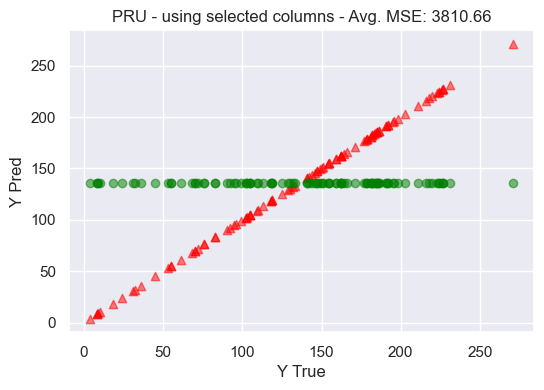

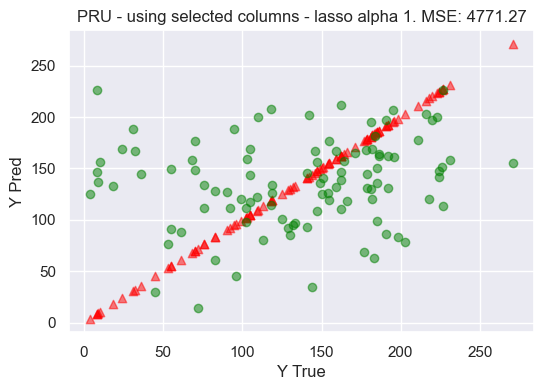

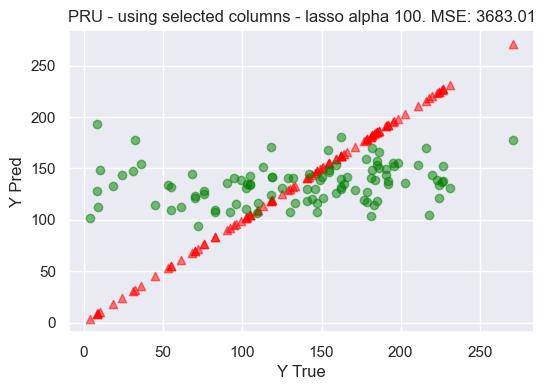

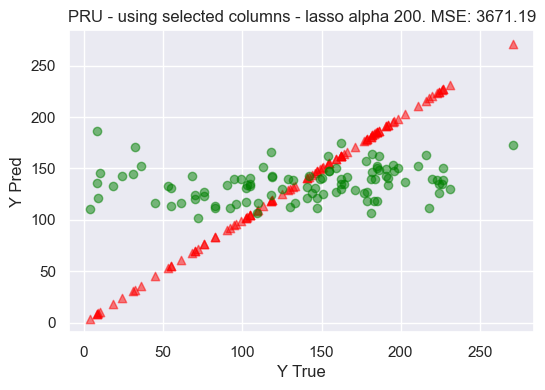

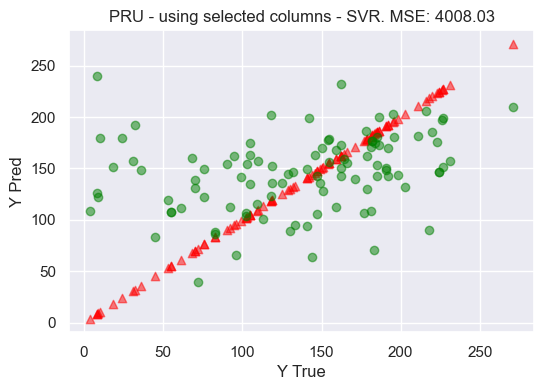

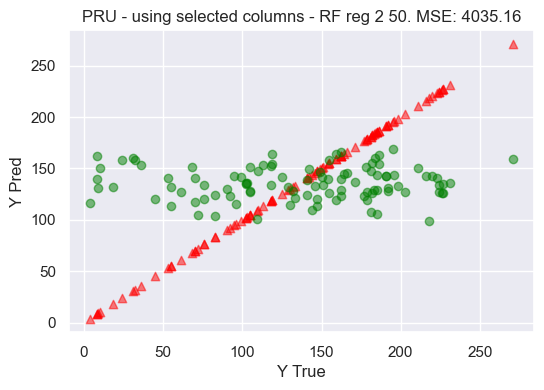

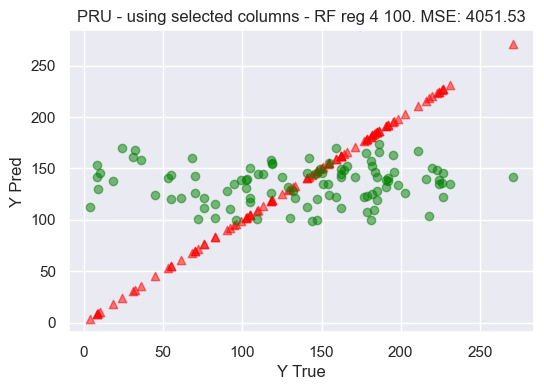

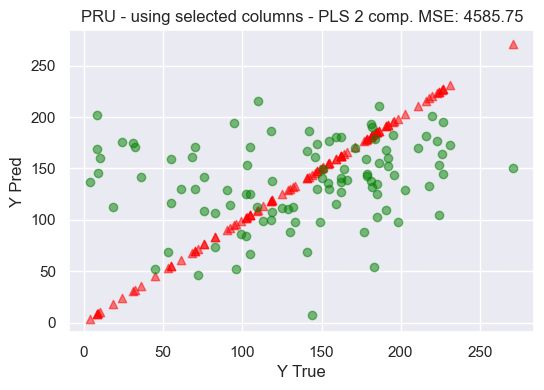

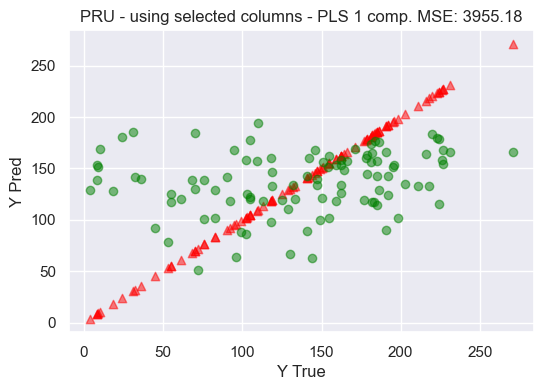

In [92]:
pred_label = 'PRU - using selected columns'
for model in preds:
    dotplot(Y, preds[model], model, pred_label)

## Clopidogrel concentration regression - All columns from both data sources

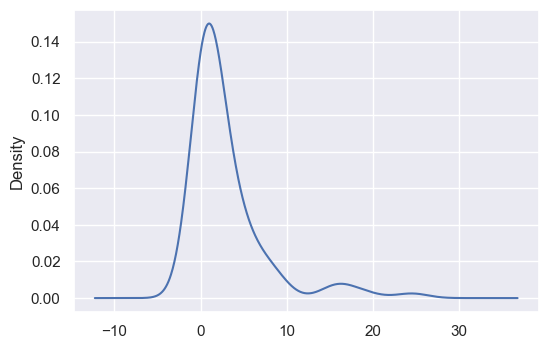

In [93]:
THRESHOLD = 100

Y_clop_concentration[Y_clop_concentration.map(lambda value: value < THRESHOLD)].plot(kind='kde')

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.42829422029956, tolerance: 0.14939012833333334
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.24960140262704, tolerance: 0.1681872948717949
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.70074048057882, tolerance: 0.16860595384615387
  model = cd_fast.enet_coordinate_descen

Resulting MSE for lasso alpha 1 is 21.03
Resulting overall r_squared for lasso alpha 1 is -0.05
Resulting MSE for lasso alpha 100 is 20.27
Resulting overall r_squared for lasso alpha 100 is -0.02
Resulting MSE for lasso alpha 200 is 20.42
Resulting overall r_squared for lasso alpha 200 is -0.03
Resulting MSE for SVR is 30.19
Resulting overall r_squared for SVR is -0.50
Resulting MSE for RF reg 2 50 is 24.46
Resulting overall r_squared for RF reg 2 50 is -0.23
Resulting MSE for RF reg 4 100 is 26.01
Resulting overall r_squared for RF reg 4 100 is -0.30
Resulting MSE for PLS 2 comp is 30.68
Resulting overall r_squared for PLS 2 comp is -0.53
Resulting MSE for PLS 1 comp is 25.43
Resulting overall r_squared for PLS 1 comp is -0.27


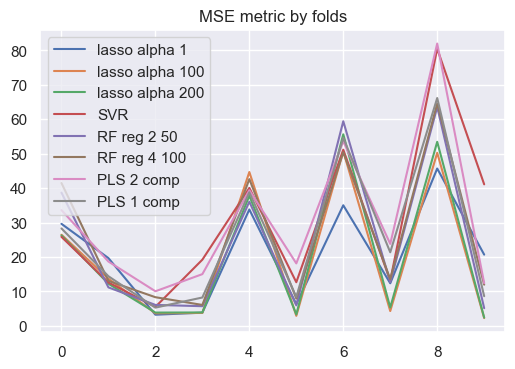

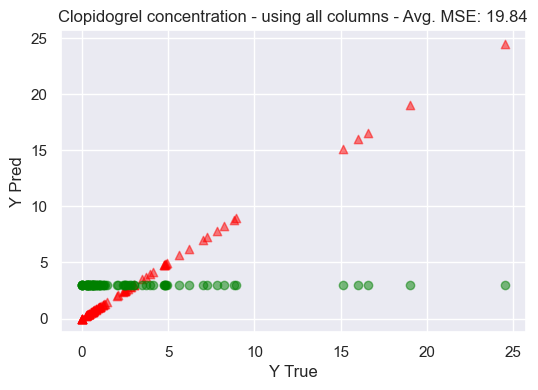

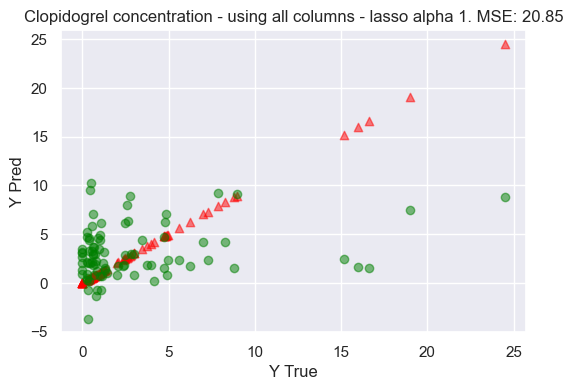

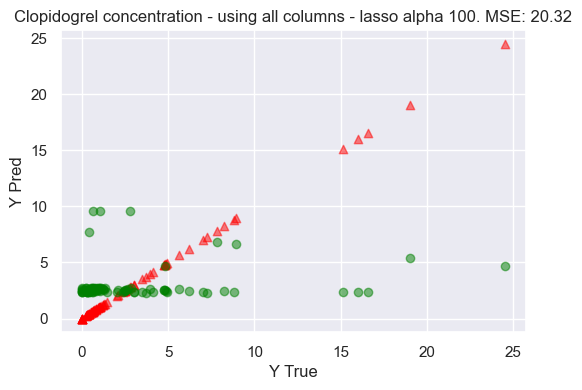

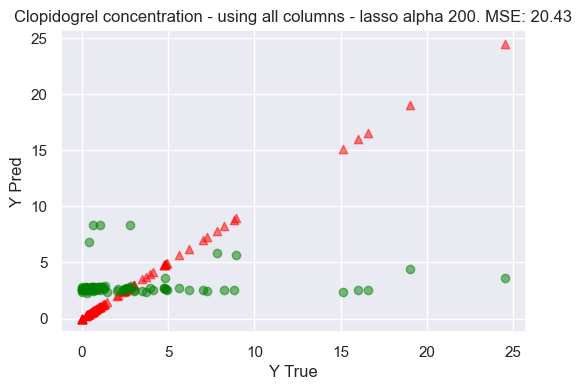

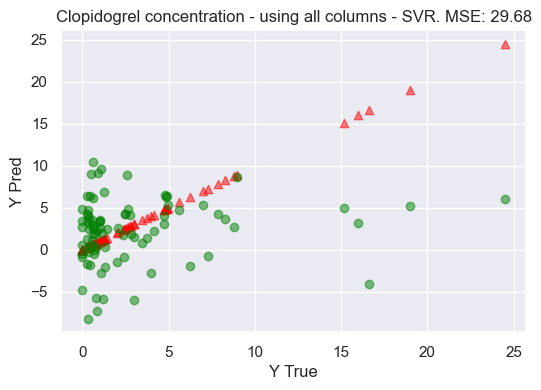

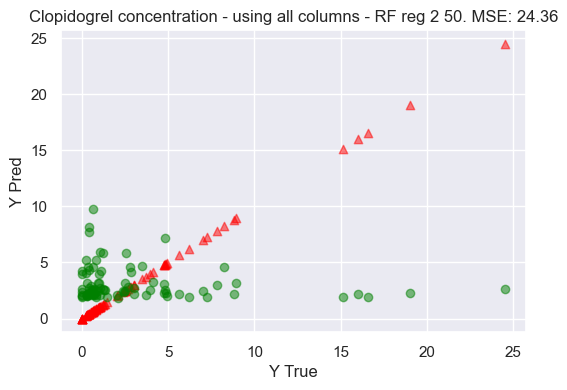

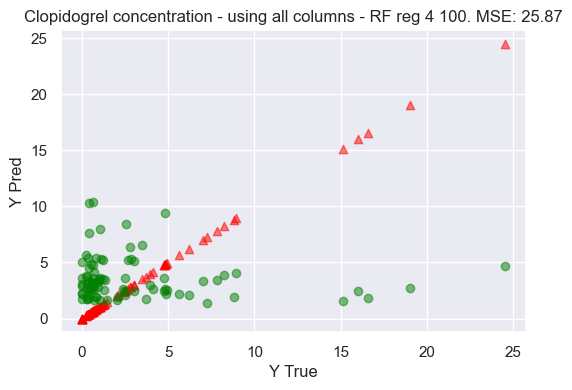

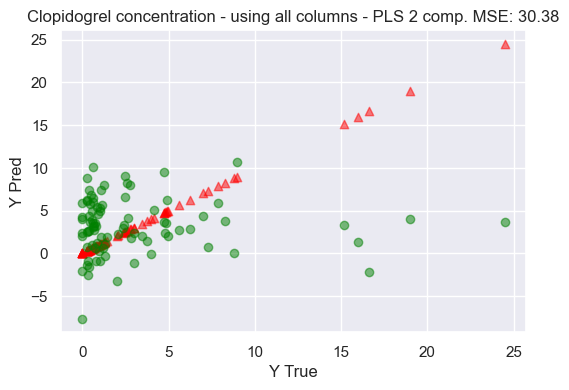

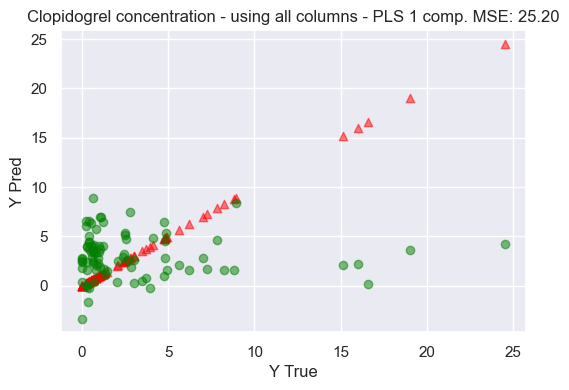

In [94]:
pred_label = 'Clopidogrel concentration - using all columns'

merged_df = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
)
Y = Y_clop_concentration[Y_clop_concentration.map(lambda value: value < THRESHOLD)]
X = merged_df.drop(columns=['Concentration']).loc[Y.index]

Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()


for model in preds:
    dotplot(Y, preds[model], model, pred_label)

## Clopidogrel analysis using only selected_cols

In [95]:
COLS = [
    *GENETICS_COLS,
    'STEMI',
'NSTEMI',
'Unstableangina',
'PCI',
'Alcohol',
'Smoking',
'Grace_score_risk',
'SYNTAX_score',
'CRUSADE',
'Killip',
'Hypertension',
'HeartFailure_before',
'Stroke',
'Previous_thromboses',
'RenalFailure',
'HeartFailure',
'DAPT_TAPT',
'GFR',
]

Resulting MSE for lasso alpha 1 is 20.81
Resulting overall r_squared for lasso alpha 1 is -0.05
Resulting MSE for lasso alpha 100 is 20.20
Resulting overall r_squared for lasso alpha 100 is -0.02
Resulting MSE for lasso alpha 200 is 20.41
Resulting overall r_squared for lasso alpha 200 is -0.03
Resulting MSE for SVR is 22.13
Resulting overall r_squared for SVR is -0.11
Resulting MSE for RF reg 2 50 is 23.97
Resulting overall r_squared for RF reg 2 50 is -0.20
Resulting MSE for RF reg 4 100 is 25.46
Resulting overall r_squared for RF reg 4 100 is -0.28
Resulting MSE for PLS 2 comp is 29.73
Resulting overall r_squared for PLS 2 comp is -0.48
Resulting MSE for PLS 1 comp is 25.06
Resulting overall r_squared for PLS 1 comp is -0.25


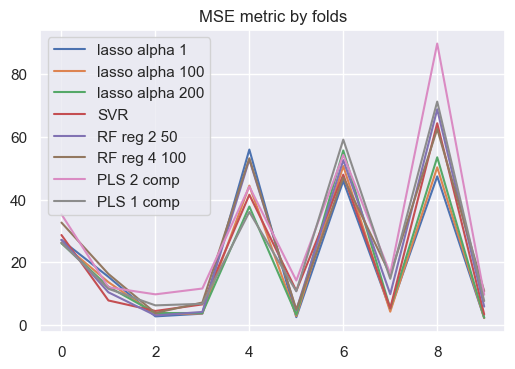

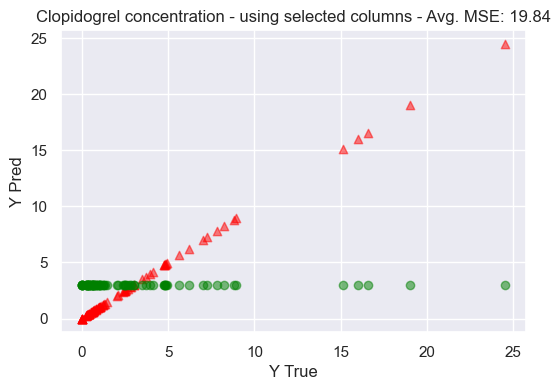

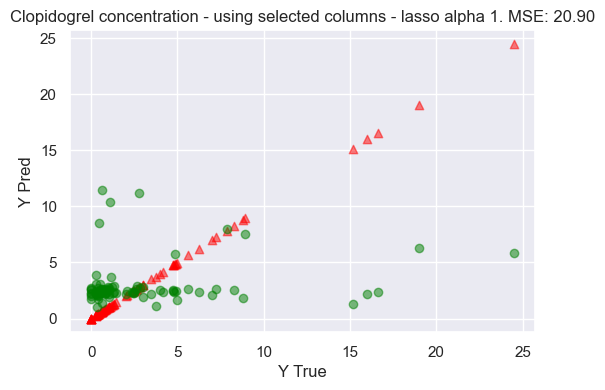

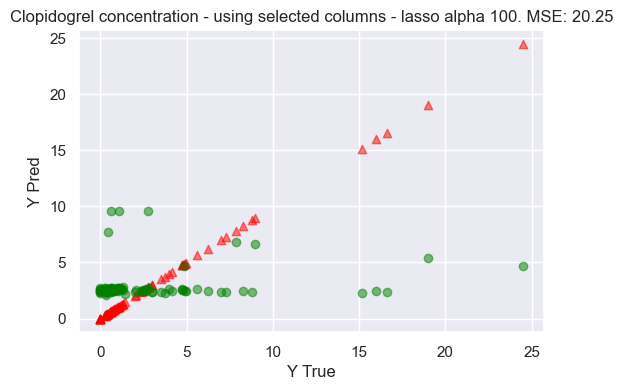

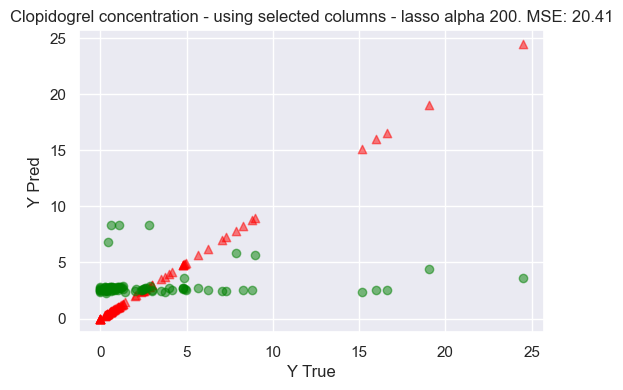

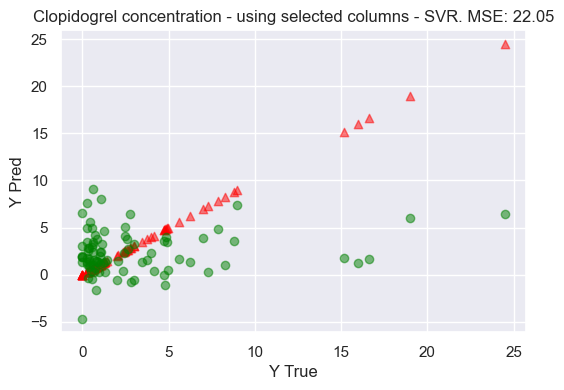

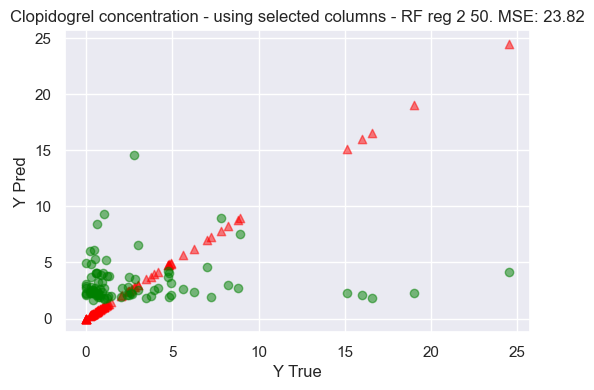

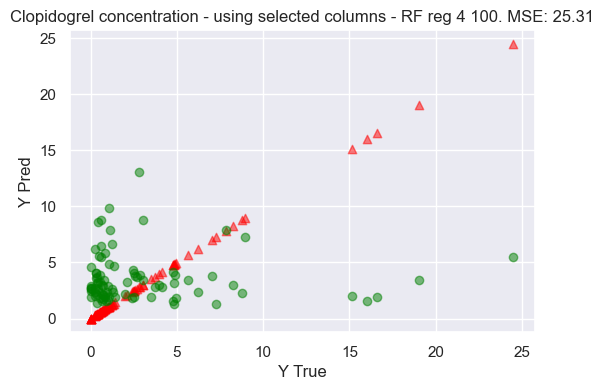

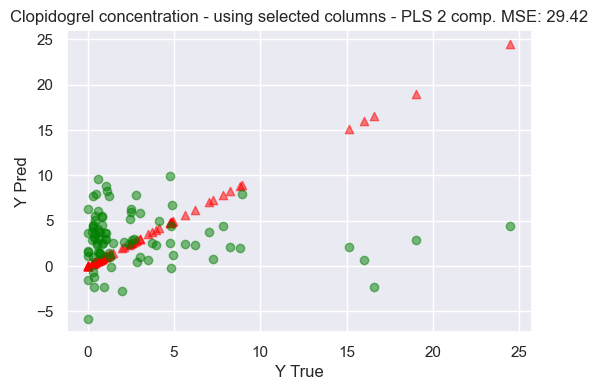

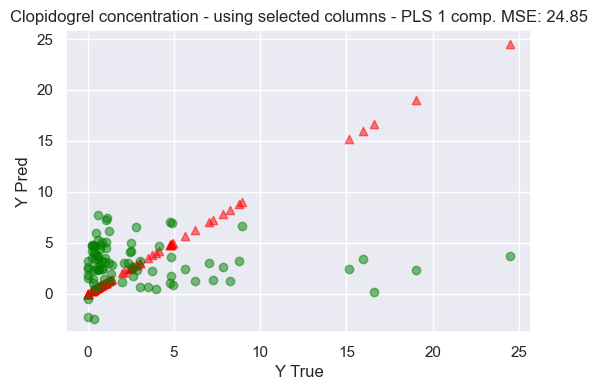

In [96]:
pred_label = 'Clopidogrel concentration - using selected columns'

merged_df = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
)
THRESHOLD = 100
Y = Y_clop_concentration[Y_clop_concentration.map(lambda value: value < THRESHOLD)]
X = merged_df.drop(columns=['Concentration']).loc[Y.index][COLS]

Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()


for model in preds:
    dotplot(Y, preds[model], model, pred_label)

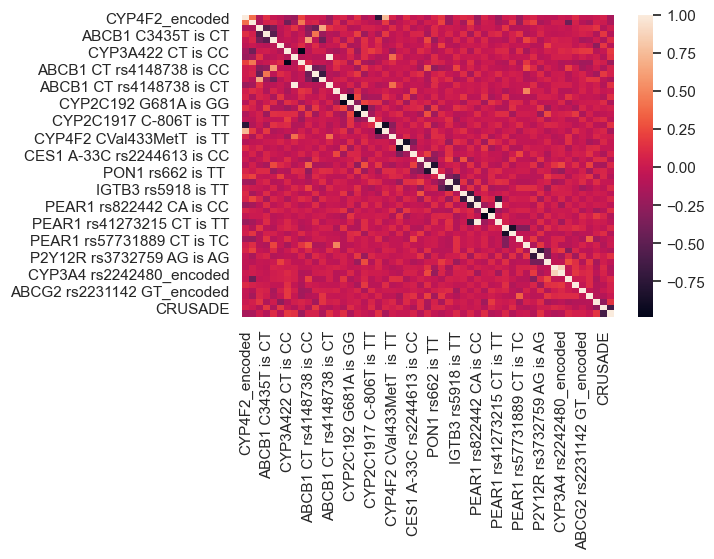

In [97]:
sns.heatmap(merged_df[COLS].corr())

## High/Low/Normal PRU classification

################################### Random Forest ###################################
Confusion matrix, without normalization
[[ 0  0 12]
 [ 0  0 25]
 [ 1  0 65]]


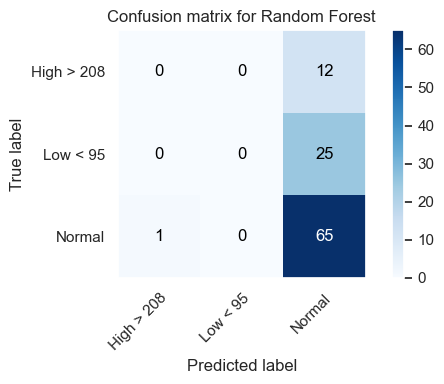

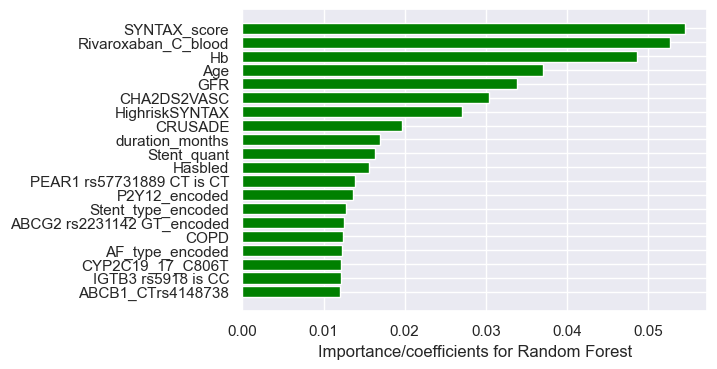

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[ 3  2  7]
 [ 6  6 13]
 [11 19 36]]


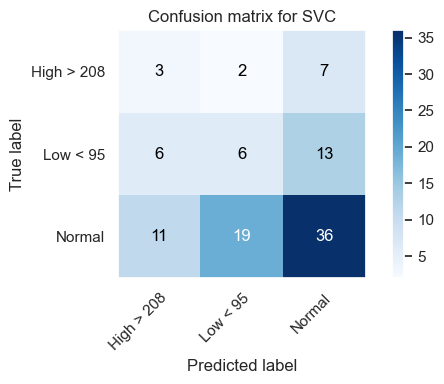

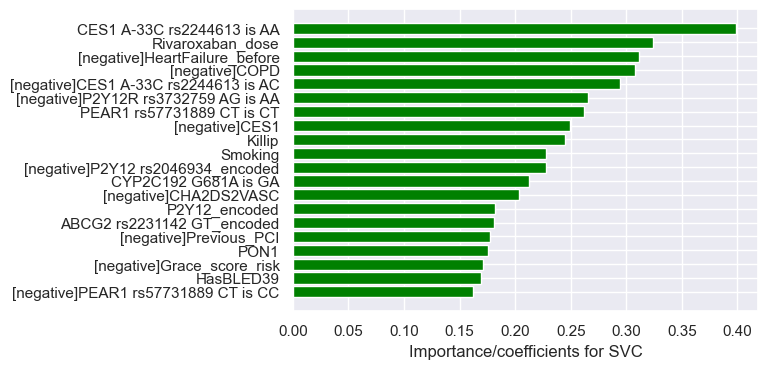

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexa

Confusion matrix, without normalization
[[ 2  2  8]
 [ 1  4 20]
 [ 5 11 50]]


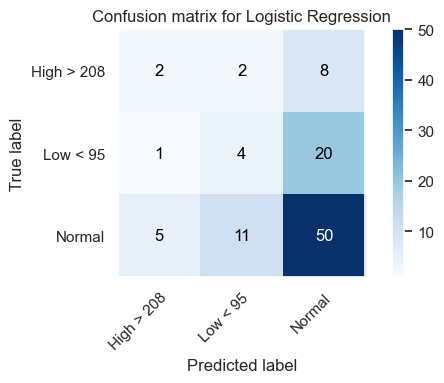

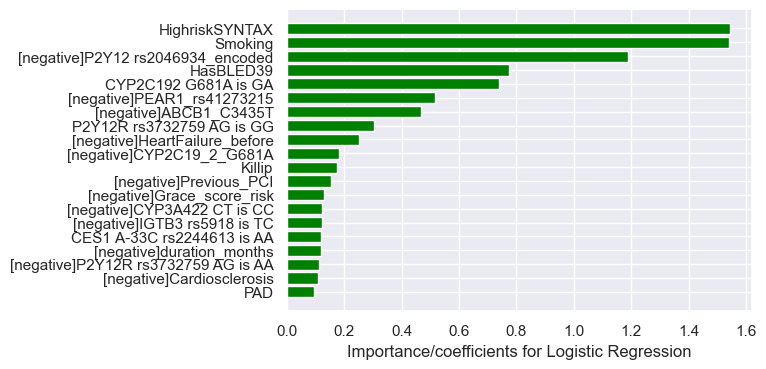

<Figure size 1000x700 with 0 Axes>

In [98]:
X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).drop(columns=['PRU', 'age', 'inhibition', 'Agr_Platelets_base']).dropna(axis=1)
encoder = LabelEncoder()
Y = pd.Series(
    encoder.fit_transform(rivaroxaban_preprocessed_df['PRU'].map(lambda x: x<95 and 'Low < 95' or x>208 and 'High > 208' or 'Normal')),
    index=X.index
)

CLASS_NAMES = encoder.classes_

rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    coefs = evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        coefs,
        name,
    )

In [99]:
Y_clop_concentration[Y_clop_concentration.map(lambda value: value < THRESHOLD)].max()

24.5

## PRU regression - Only significant columns from both data sources

Resulting MSE for lasso alpha 1 is 3781.35
Resulting overall r_squared for lasso alpha 1 is -0.03
Resulting MSE for lasso alpha 100 is 3788.03
Resulting overall r_squared for lasso alpha 100 is -0.03
Resulting MSE for lasso alpha 200 is 3787.56
Resulting overall r_squared for lasso alpha 200 is -0.03
Resulting MSE for SVR is 3971.65
Resulting overall r_squared for SVR is -0.08
Resulting MSE for RF reg 2 50 is 3790.06
Resulting overall r_squared for RF reg 2 50 is -0.04
Resulting MSE for RF reg 4 100 is 4065.46
Resulting overall r_squared for RF reg 4 100 is -0.11
Resulting MSE for PLS 2 comp is 3818.06
Resulting overall r_squared for PLS 2 comp is -0.04
Resulting MSE for PLS 1 comp is 3817.49
Resulting overall r_squared for PLS 1 comp is -0.05


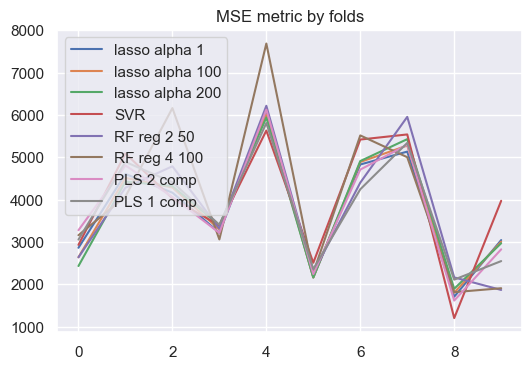

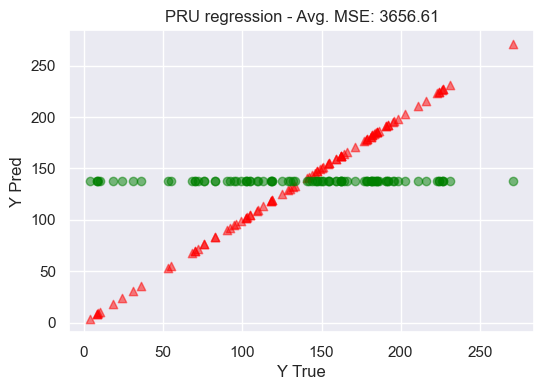

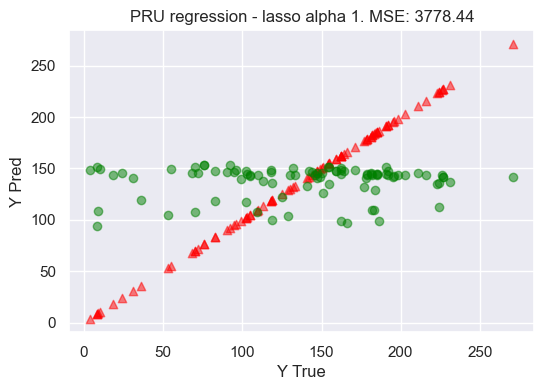

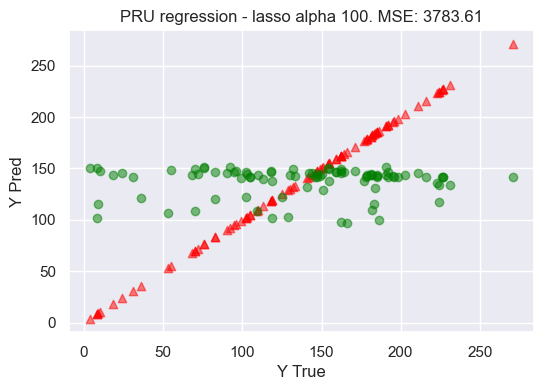

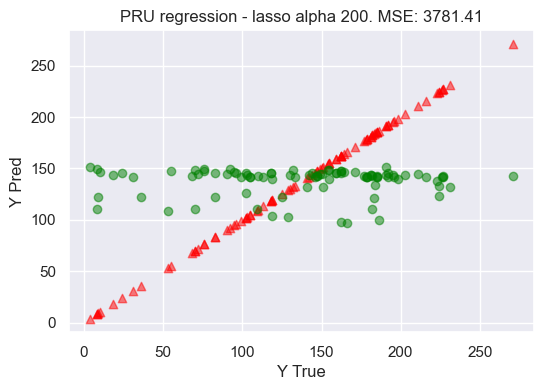

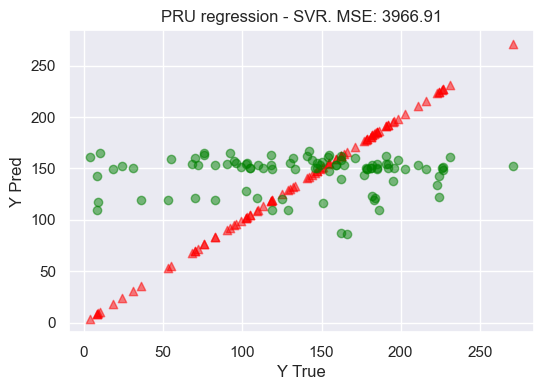

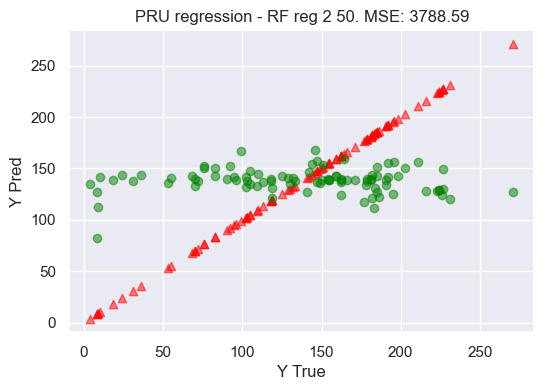

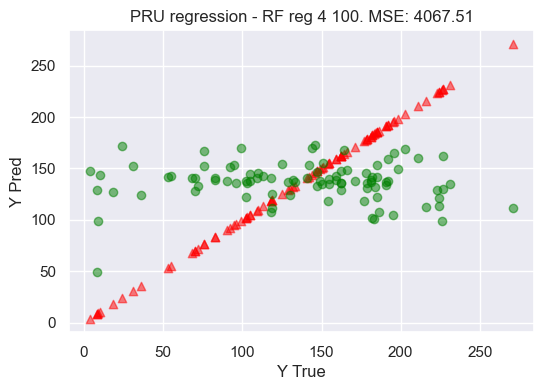

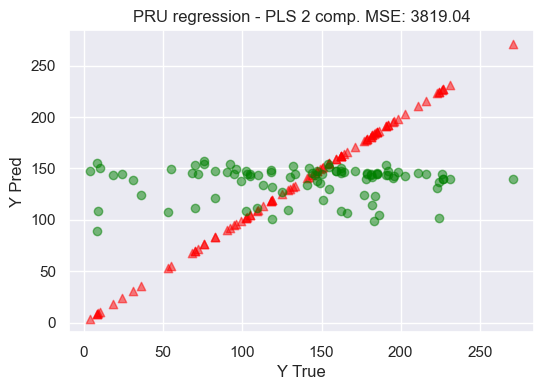

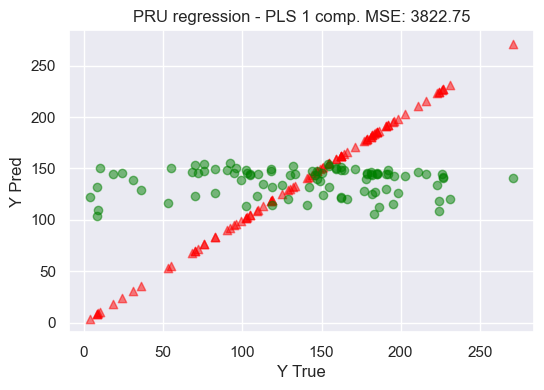

In [101]:
pred_label = 'PRU regression'

X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['PRU'])
encoder = LabelEncoder()
Y = Y_PRU[X.index]

SIGNIFICANT_COLS = [ col for col in
    X.columns[
    pd.Series(dict(PRU_all_cols_regr_models)['lasso alpha 100'].coef_).map(lambda x: abs(x)>0)
]
    if col not in ['inhibition', 'Agr_Platelets_base']
]


X = X[SIGNIFICANT_COLS]
Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()
for model in preds:
    dotplot(Y, preds[model], model, pred_label)

In [102]:
SIGNIFICANT_COLS

['Rivaroxaban_C_blood', 'Access', 'Stent_quant']

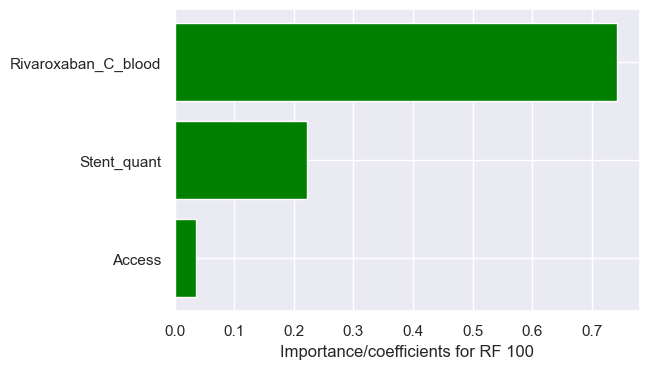

<Figure size 1000x700 with 0 Axes>

In [103]:
plot_important_features(X, dict(regression_models)['RF reg 4 100'].feature_importances_, 'RF 100')

In [ ]:
plot_important_features(X, dict(regression_models)['SVR'].coef_[0], 'SVR')


In [ ]:
plot_important_features(X, dict(regression_models)['lasso alpha 100'].coef_, 'lasso alpha 100')


In [ ]:
pred_label = 'PRU regression'

NEW_SIGNIFICANT_COLS = ['Agr_Platelets_base', 'inhibition']
X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['PRU',])[NEW_SIGNIFICANT_COLS]
encoder = LabelEncoder()
Y = Y_PRU[X.index]


Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()
for model in preds:
    dotplot(Y, preds[model], model, pred_label)

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23929.857055069857, tolerance: 32.488895238095246
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29290.671844405115, tolerance: 30.119057142857148
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32694.540191785527, tolerance: 29.935441666666666
  model = cd_fast.enet_coordinate_descent

Resulting MSE for lasso alpha 1 is 2087.92
Resulting overall r_squared for lasso alpha 1 is 0.43
Resulting MSE for lasso alpha 100 is 1871.18
Resulting overall r_squared for lasso alpha 100 is 0.50
Resulting MSE for lasso alpha 200 is 1974.48
Resulting overall r_squared for lasso alpha 200 is 0.47
Resulting MSE for SVR is 2013.58
Resulting overall r_squared for SVR is 0.45
Resulting MSE for RF reg 2 50 is 1864.34
Resulting overall r_squared for RF reg 2 50 is 0.50
Resulting MSE for RF reg 4 100 is 1849.35
Resulting overall r_squared for RF reg 4 100 is 0.50
Resulting MSE for PLS 2 comp is 2653.97
Resulting overall r_squared for PLS 2 comp is 0.27
Resulting MSE for PLS 1 comp is 3148.23
Resulting overall r_squared for PLS 1 comp is 0.13


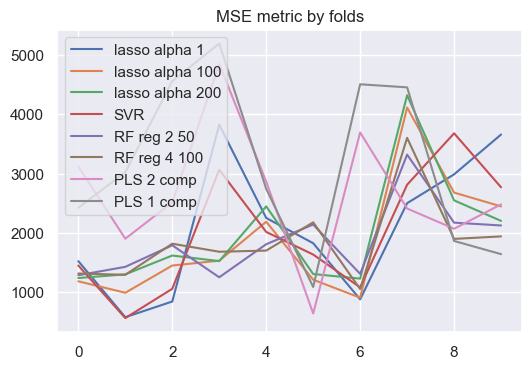

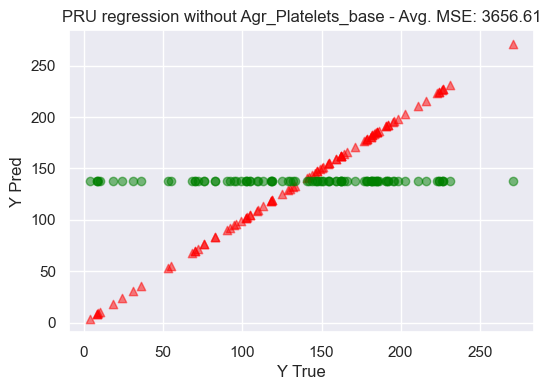

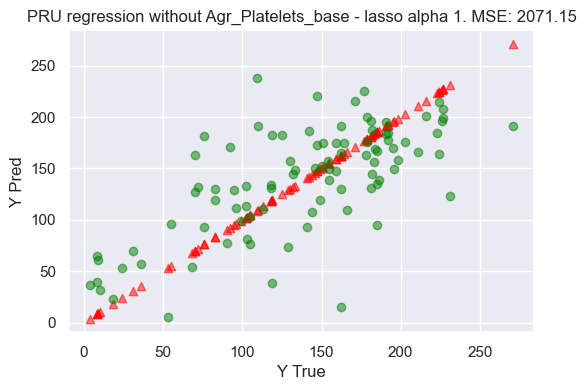

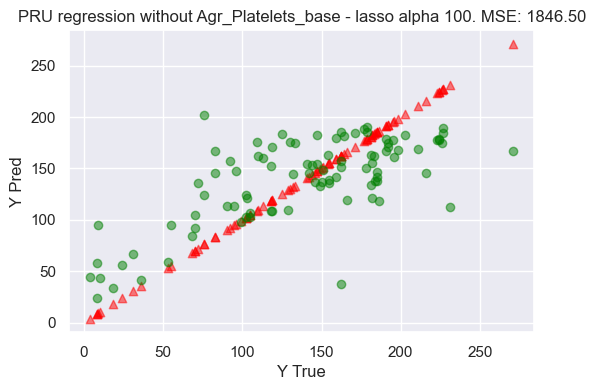

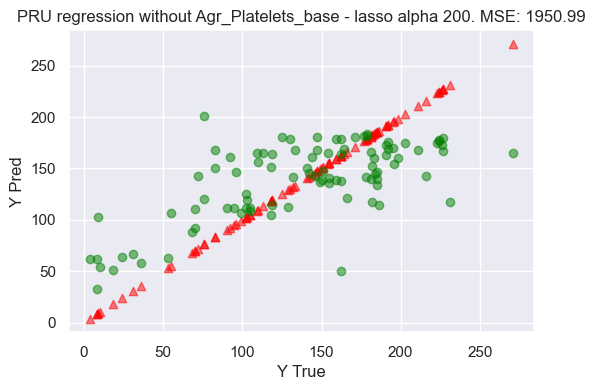

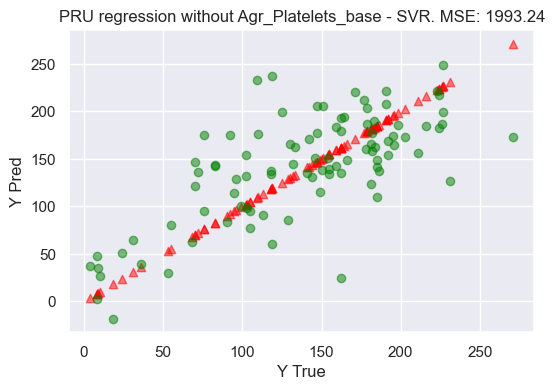

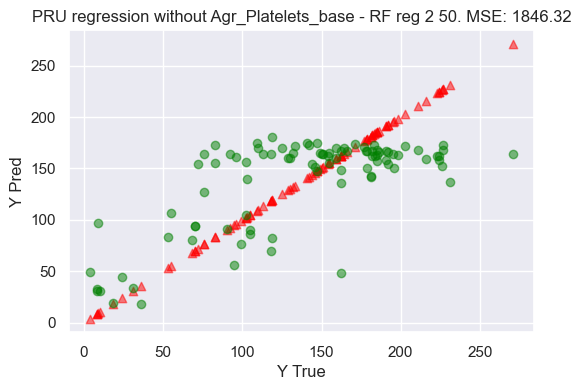

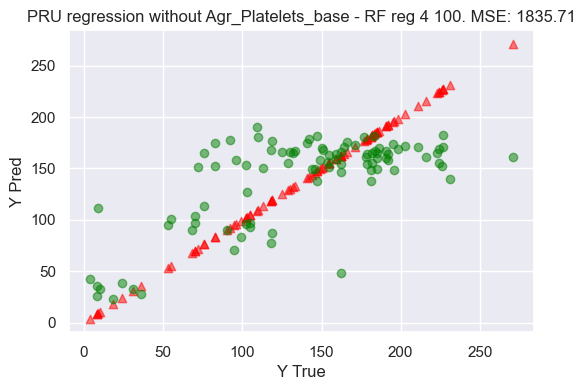

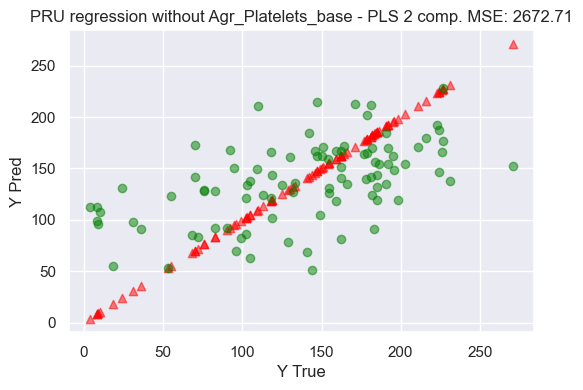

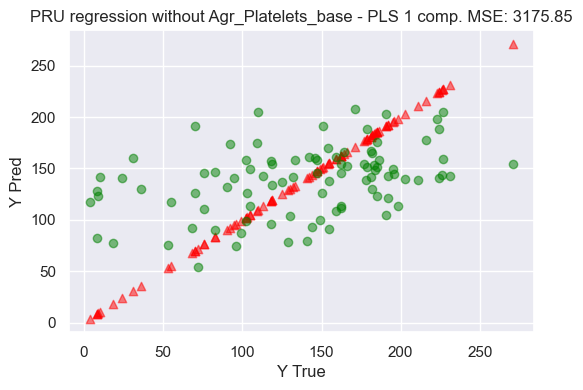

In [440]:
pred_label = 'PRU regression without Agr_Platelets_base'

X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['PRU', 'Agr_Platelets_base'])
encoder = LabelEncoder()
Y = Y_PRU[X.index]


Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()
for model in preds:
    dotplot(Y, preds[model], model, pred_label)

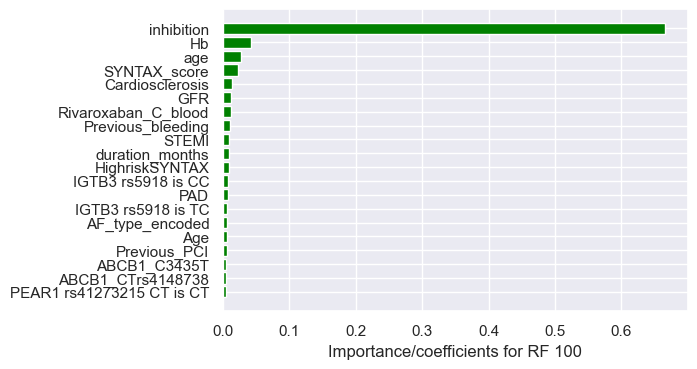

<Figure size 1000x700 with 0 Axes>

In [441]:
plot_important_features(X, dict(regression_models)['RF reg 4 100'].feature_importances_, 'RF 100')

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77594.92411358848, tolerance: 32.488895238095246
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76823.6344993797, tolerance: 30.119057142857148
  model = cd_fast.enet_coordinate_descent(
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79653.48309316928, tolerance: 29.935441666666666
  model = cd_fast.enet_coordinate_descent(
/U

Resulting MSE for lasso alpha 1 is 4605.38
Resulting overall r_squared for lasso alpha 1 is -0.26
Resulting MSE for lasso alpha 100 is 3549.73
Resulting overall r_squared for lasso alpha 100 is 0.03
Resulting MSE for lasso alpha 200 is 3720.58
Resulting overall r_squared for lasso alpha 200 is -0.02
Resulting MSE for SVR is 3699.04
Resulting overall r_squared for SVR is -0.00
Resulting MSE for RF reg 2 50 is 3800.92
Resulting overall r_squared for RF reg 2 50 is -0.04
Resulting MSE for RF reg 4 100 is 3958.41
Resulting overall r_squared for RF reg 4 100 is -0.09
Resulting MSE for PLS 2 comp is 4365.29
Resulting overall r_squared for PLS 2 comp is -0.20
Resulting MSE for PLS 1 comp is 4019.74
Resulting overall r_squared for PLS 1 comp is -0.11


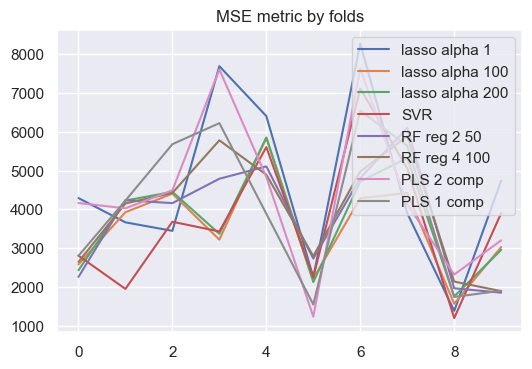

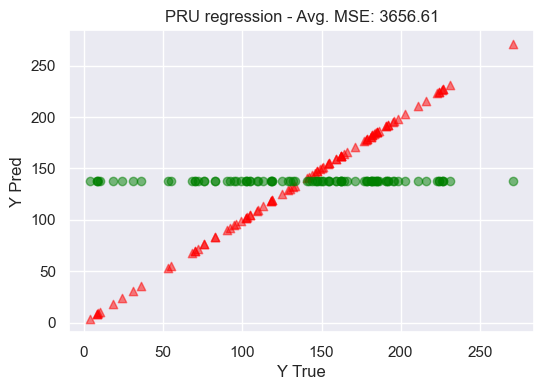

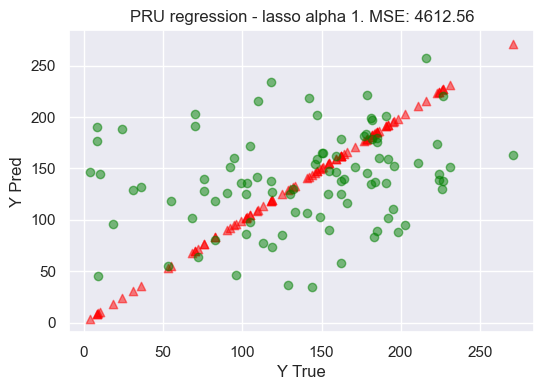

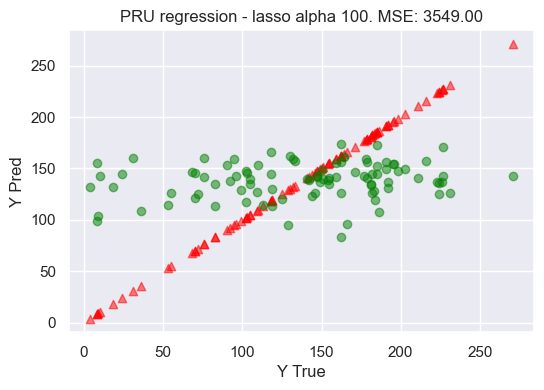

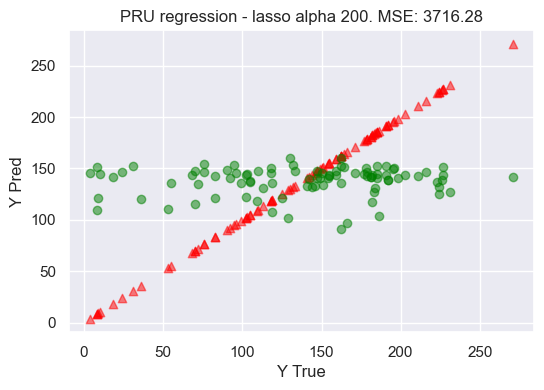

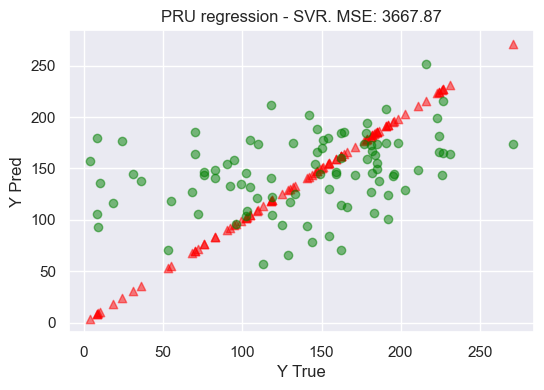

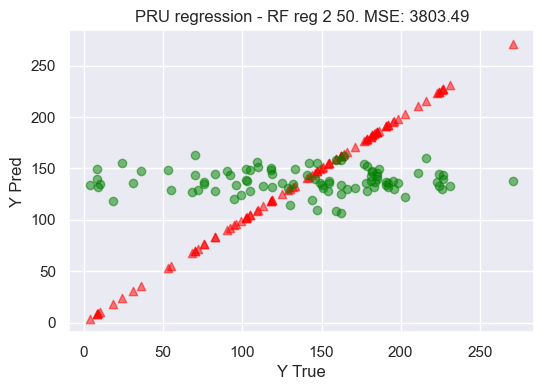

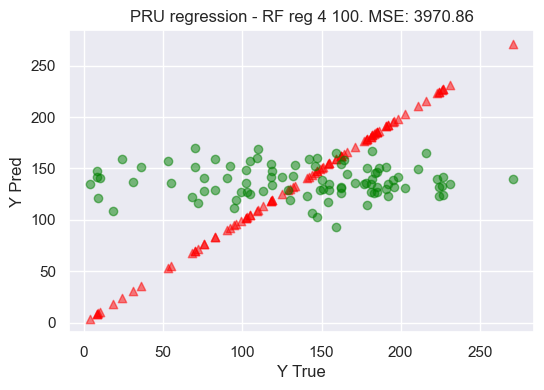

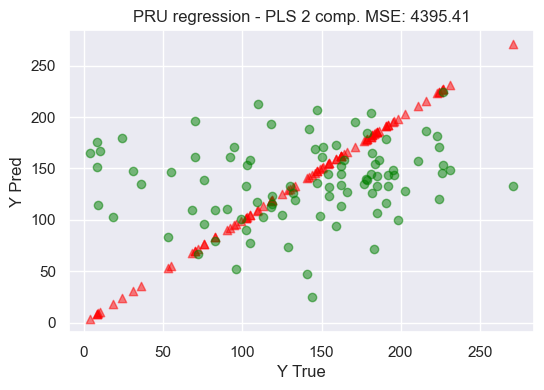

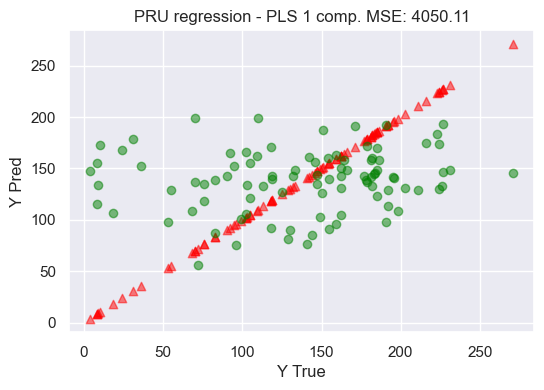

In [442]:
pred_label = 'PRU regression'

NEW_SIGNIFICANT_COLS = ['Agr_Platelets_base', 'inhibition']
X = rivaroxaban_preprocessed_df.merge(
    processed_clop_genetics_df, left_index=True, right_index=True
).dropna().drop(columns=['PRU', *NEW_SIGNIFICANT_COLS])
encoder = LabelEncoder()
Y = Y_PRU[X.index]


Y_avg = np.full(Y.shape[0], Y.mean())
baseline_mse = mean_squared_error(Y, Y_avg)
baseline_mse

regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['lasso alpha 200', linear_model.Lasso(alpha=200, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]
preds = {'Avg': Y_avg}
for model_name, model in regression_models:
    preds[model_name] = evaluate_regression_model(model, X, Y, model_name)
plt.legend([i[0] for i in regression_models])
plt.show()
for model in preds:
    dotplot(Y, preds[model], model, pred_label)